## Preprocessing

### Imports

In [1]:
import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
from IPython.core.display_functions import display
from biogeme.expressions import Beta, Variable
from biogeme.models import loglogit, boxcox
from biogeme.segmentation import DiscreteSegmentationTuple, segmented_beta

### Load Data and Filter

Remove all those who shouldn't have access to cars but still chose it

In [ ]:
data = pd.read_csv("lpmc01.dat", sep = '\t')
#
# Step 1: Identify whether each household has a driving license
data['household_has_license'] = data.groupby('household_id')['driving_license'].transform(lambda x: x.max())

# Step 2: Define a filter for the availability conditions not being met
car_availability_unmet = (data['car_ownership'] == 0) & (data['driving_license'] == 0) & (data['household_has_license'] == 0)

# Step 3: Identify rows where travel_mode is 4 (car) but the availability conditions are not met
car_without_availability = data[(data['travel_mode'] == 4) & car_availability_unmet]

# Step 4: Remove those rows from the original DataFrame
data_filtered = data[~data.index.isin(car_without_availability.index)]

database = db.Database('london', data_filtered)

### Explore Data 

Check statistics and graphs of Data

In [3]:
data_filtered.describe()

,trip_id,household_id,person_n,trip_n,travel_mode,purpose,fueltype,faretype,bus_scale,survey_year,...,dur_pt_rail,dur_pt_bus,dur_pt_int,pt_interchanges,dur_driving,cost_transit,cost_driving_fuel,cost_driving_ccharge,driving_traffic_percent,household_has_license
count,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,...,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000,4941.000000
mean,40237.209472,8643.030763,0.773932,1.538353,3.047359,2.888687,2.780814,2.205829,0.662619,1.974094,...,0.091402,0.172350,0.044814,0.371180,0.284220,1.599806,0.837735,1.145416,0.336556,0.689334
std,23379.474440,5064.169881,1.027603,1.768024,1.081396,1.188233,2.218510,1.720187,0.466398,0.816912,...,0.175669,0.190150,0.078959,0.623633,0.253322,1.525741,0.821638,3.273692,0.200867,0.462813
min,12.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.009722,0.000000,0.030000,0.000000,0.000000,0.000000
25%,19903.000000,4214.000000,0.000000,0.000000,3.000000,2.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.035833,0.000000,0.000000,0.107500,0.000000,0.280000,0.000000,0.172973,0.000000
50%,40280.000000,8615.000000,0.000000,1.000000,3.000000,3.000000,2.000000,1.000000,1.000000,2.000000,...,0.000000,0.111111,0.000000,0.000000,0.189167,1.500000,0.540000,0.000000,0.304348,1.000000
75%,60195.000000,12907.000000,1.000000,2.000000,4.000000,3.000000,6.000000,4.000000,1.000000,3.000000,...,0.100000,0.250000,0.091667,1.000000,0.378056,2.400000,1.120000,0.000000,0.488011,1.000000
max,81084.000000,17615.000000,7.000000,14.000000,4.000000,5.000000,6.000000,5.000000,1.000000,3.000000,...,1.183333,1.871944,0.750000,4.000000,1.730556,10.600000,8.630000,10.500000,0.957627,1.000000


In [4]:
pt_data = data_filtered[data_filtered['travel_mode'] == 3]

pt_data[['cost_transit', 'faretype', 'bus_scale']].describe()

,cost_transit,faretype,bus_scale
count,1766.000000,1766.000000,1766.000000
mean,1.947571,2.270102,0.636183
std,1.853382,1.710186,0.471270
min,0.000000,1.000000,0.000000
25%,0.000000,1.000000,0.000000
50%,1.500000,1.000000,1.000000
75%,3.000000,4.000000,1.000000
max,10.100000,5.000000,1.000000


In [ ]:
hist = pt_data[['bus_scale','cost_transit','purpose','faretype']].hist()


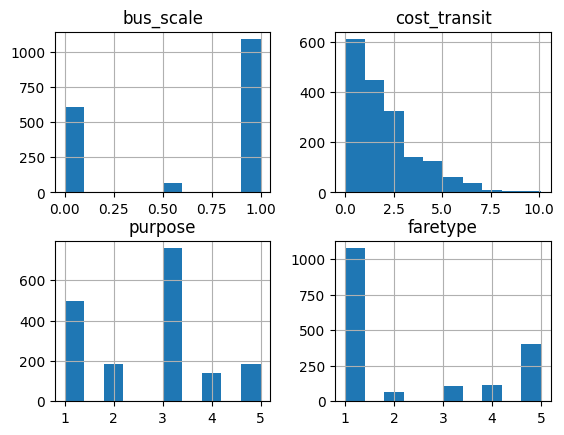

In [5]:
hist = pt_data[['bus_scale','cost_transit','purpose','faretype']].hist()


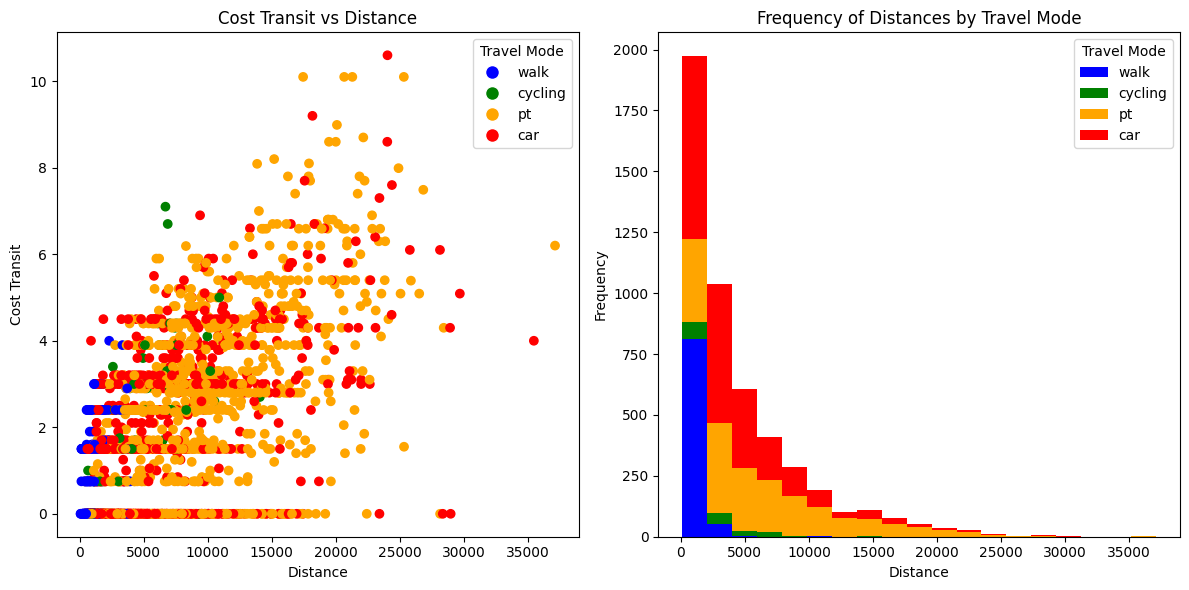

In [6]:
distance = data_filtered['distance']
cost_transit = data_filtered['cost_transit']
choice = data_filtered['travel_mode']
choices = ['walk', 'cycling', 'pt', 'car']

import matplotlib.pyplot as plt
import numpy as np

# Define colors for each choice (1, 2, 3, 4)
color_map = {1: 'blue', 2: 'green', 3: 'orange', 4: 'red'}
labels = {1: 'walk', 2: 'cycling', 3: 'pt', 4: 'car'}

# Separate distances by travel mode
distance_by_mode = {mode: distance[choice == mode] for mode in color_map}

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot with color based on choice
colors = [color_map[c] for c in choice]
axes[0].scatter(distance, cost_transit, c=colors)
axes[0].set_title("Cost Transit vs Distance")
axes[0].set_xlabel("Distance")
axes[0].set_ylabel("Cost Transit")

# Create custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[i], markersize=10, label=labels[i]) for i in color_map]
axes[0].legend(handles=legend_elements, title="Travel Mode")

# Stacked histogram for travel modes
bins = np.linspace(min(distance), max(distance), 20)
hist_data = [distance_by_mode[mode] for mode in color_map]
axes[1].hist(hist_data, bins=bins, stacked=True, color=[color_map[i] for i in color_map], label=[labels[i] for i in color_map])

axes[1].set_xlabel("Distance")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Frequency of Distances by Travel Mode")
axes[1].legend(title="Travel Mode")

plt.tight_layout()
plt.show()


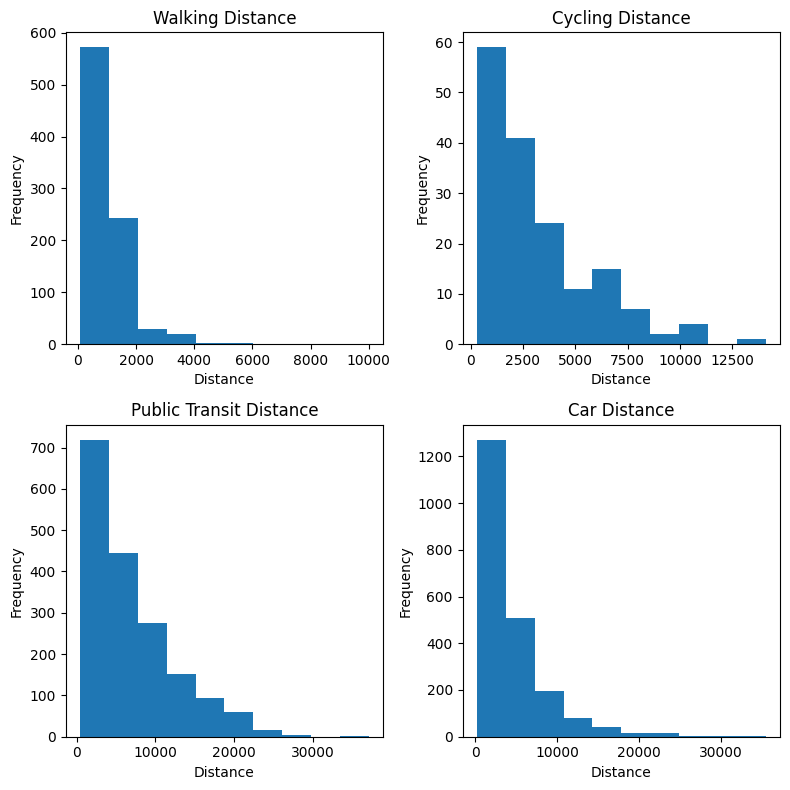

In [7]:
walk_distance = distance[choice == 1]
cycling_distance = distance[choice == 2]
pt_distance = distance[choice == 3]
car_distance = distance[choice == 4]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

# Plot histograms for each travel mode with titles
axes[0].hist(walk_distance)
axes[0].set_title("Walking Distance")
axes[0].set_xlabel("Distance")
axes[0].set_ylabel("Frequency")

axes[1].hist(cycling_distance)
axes[1].set_title("Cycling Distance")
axes[1].set_xlabel("Distance")
axes[1].set_ylabel("Frequency")

axes[2].hist(pt_distance)
axes[2].set_title("Public Transit Distance")
axes[2].set_xlabel("Distance")
axes[2].set_ylabel("Frequency")

axes[3].hist(car_distance)
axes[3].set_title("Car Distance")
axes[3].set_xlabel("Distance")
axes[3].set_ylabel("Frequency")

plt.tight_layout()
plt.show()




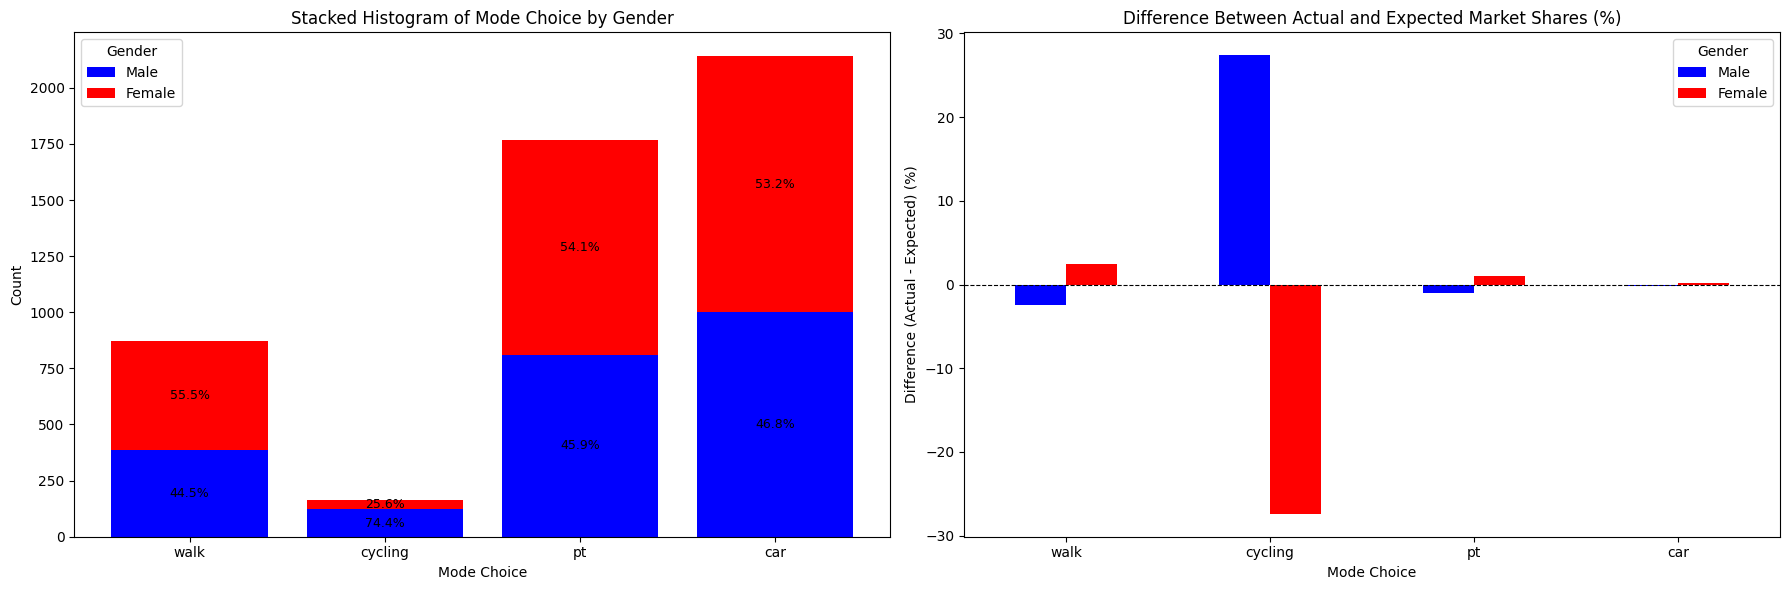

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulated or existing dataset
# Ensure your `data_filtered` DataFrame has the columns 'female' and 'travel_mode'

# Filter data for each mode and gender (female: 1, male: 0)
counts = data_filtered.groupby(['travel_mode', 'female']).size().unstack(fill_value=0)

# Define consistent color palette for gender
gender_colors = ['blue', 'red']  # Blue for male (0), Red for female (1)

# Compute the total population per gender
gender_totals = data_filtered['female'].value_counts(sort=False)

# Compute the weights for each gender
gender_weights = gender_totals / gender_totals.sum()

# Compute actual shares
total_counts = counts.sum(axis=1)
actual_shares = counts.div(total_counts, axis=0)

# Compute expected shares based on gender weights
expected_shares = pd.DataFrame(
    {gender: gender_weights[gender] for gender in counts.columns},
    index=counts.index
)

# Compute differences
differences = (actual_shares - expected_shares) * 100

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

mode_choices = ['walk', 'cycling', 'pt', 'car']

# First subplot: Stacked bar chart for gender
ax1 = axes[0]
bar_positions = np.arange(len(mode_choices))
bar_width = 0.8

# Plot stacked bar chart and add market share annotations
cumulative_bottom = np.zeros(len(mode_choices))

# Iterate over the genders
for idx, gender in enumerate([0, 1]):  # 0 is male, 1 is female
    heights = counts[gender]
    ax1.bar(bar_positions, heights, bottom=cumulative_bottom, color=gender_colors[idx], label='Female' if gender == 1 else 'Male', width=bar_width)
    
    # Add market share annotations centered in each stack
    for i, (bottom, height) in enumerate(zip(cumulative_bottom, heights)):
        if height > 0:  # Only annotate non-zero stacks
            market_share = f"{(actual_shares.iloc[i, idx] * 100):.1f}%"
            ax1.text(
                i,  # x-position
                bottom + height / 2,  # y-position
                market_share,  # text
                ha='center', va='center', fontsize=9, color='black'
            )
    cumulative_bottom += heights

ax1.set_xlabel('Mode Choice')
ax1.set_ylabel('Count')
ax1.set_title('Stacked Histogram of Mode Choice by Gender')
ax1.legend(title="Gender")
ax1.set_xticks(bar_positions)
ax1.set_xticklabels(mode_choices, rotation=0)

# Second subplot: Difference between actual and expected market shares for gender
ax2 = axes[1]
differences.plot(kind='bar', color=gender_colors, ax=ax2)
ax2.legend(['Male', 'Female'], title="Gender")
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add baseline at y=0
ax2.set_xlabel('Mode Choice')
ax2.set_ylabel('Difference (Actual - Expected) (%)')
ax2.set_title('Difference Between Actual and Expected Market Shares (%)')
ax2.set_xticks(range(len(mode_choices)))
ax2.set_xticklabels(mode_choices, rotation=0)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


C:\Users\mathi\AppData\Local\Temp\ipykernel_11632\238730340.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['age_group'] = pd.cut(data_filtered['age'], bins=age_bins, labels=age_labels, right=False)
C:\Users\mathi\AppData\Local\Temp\ipykernel_11632\238730340.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data_filtered.groupby(['travel_mode', 'age_group']).size().unstack(fill_value=0)


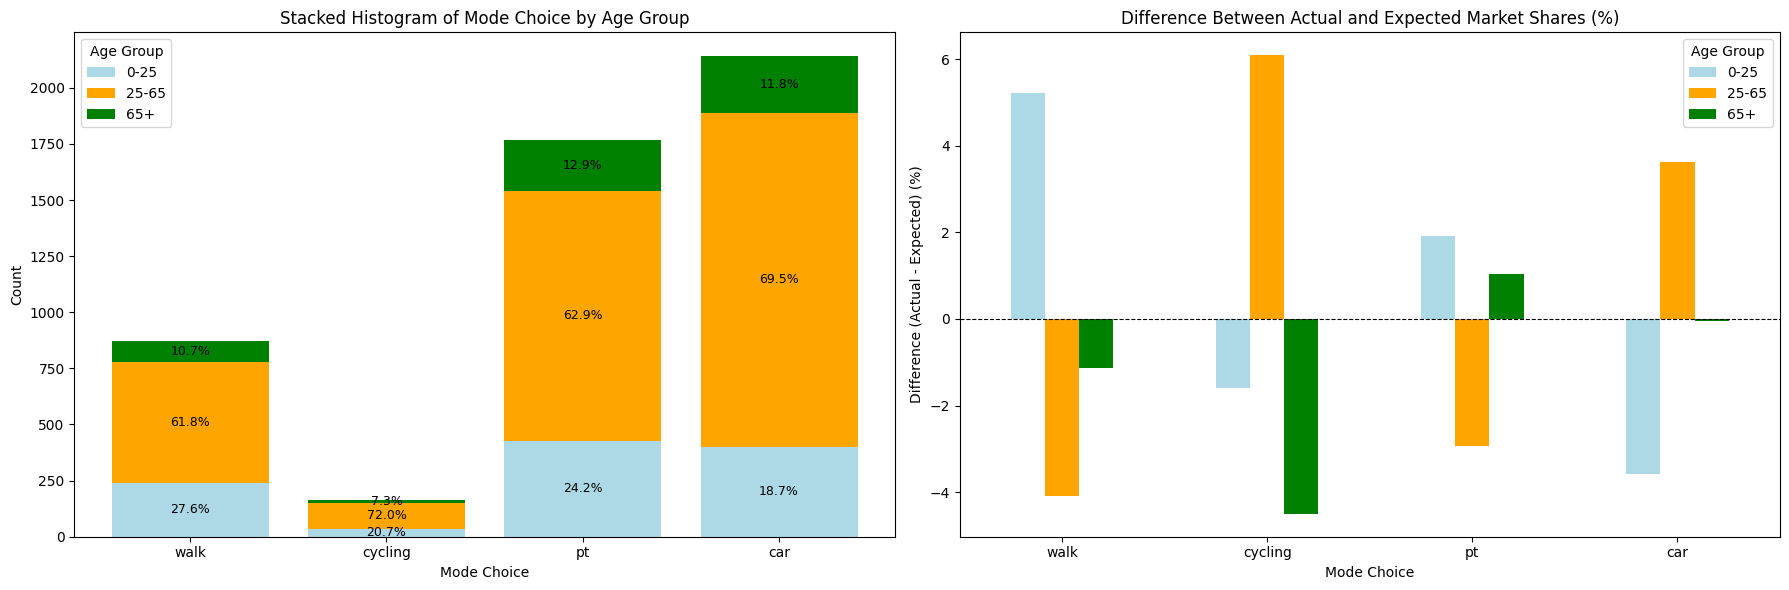

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulated or existing dataset
# Ensure your `data_filtered` DataFrame has the columns 'age', 'travel_mode'

# Define age categories
age_bins = [0, 25, 65, float('inf')]
age_labels = ['0-25', '25-65', '65+']
data_filtered['age_group'] = pd.cut(data_filtered['age'], bins=age_bins, labels=age_labels, right=False)

# Filter data for each mode and age group
counts = data_filtered.groupby(['travel_mode', 'age_group']).size().unstack(fill_value=0)

# Define consistent color palette for age groups
age_colors = ['lightblue', 'orange', 'green', 'purple']

# Compute the total population per age group
age_group_totals = data_filtered['age_group'].value_counts(sort=False)

# Compute the weights for each age group
age_group_weights = age_group_totals / age_group_totals.sum()

# Compute actual shares
total_counts = counts.sum(axis=1)
actual_shares = counts.div(total_counts, axis=0)

# Compute expected shares based on age group weights
expected_shares = pd.DataFrame(
    {group: age_group_weights[group] for group in counts.columns},
    index=counts.index
)

# Compute differences
differences = (actual_shares - expected_shares) * 100

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

mode_choices = ['walk', 'cycling', 'pt', 'car']

# First subplot: Stacked bar chart
ax1 = axes[0]
bar_positions = np.arange(len(mode_choices))
bar_width = 0.8

# Plot stacked bar chart and add market share annotations
cumulative_bottom = np.zeros(len(mode_choices))

for idx, age_group in enumerate(age_labels):
    heights = counts[age_group]
    ax1.bar(bar_positions, heights, bottom=cumulative_bottom, color=age_colors[idx], label=age_group, width=bar_width)
    
    # Add market share annotations centered in each stack
    for i, (bottom, height) in enumerate(zip(cumulative_bottom, heights)):
        if height > 0:  # Only annotate non-zero stacks
            market_share = f"{(actual_shares.iloc[i, idx] * 100):.1f}%"
            ax1.text(
                i,  # x-position
                bottom + height / 2,  # y-position
                market_share,  # text
                ha='center', va='center', fontsize=9, color='black'
            )
    cumulative_bottom += heights

ax1.set_xlabel('Mode Choice')
ax1.set_ylabel('Count')
ax1.set_title('Stacked Histogram of Mode Choice by Age Group')
ax1.legend(title="Age Group")
ax1.set_xticks(bar_positions)
ax1.set_xticklabels(mode_choices, rotation=0)

# Second subplot: Difference between actual and expected market shares
ax2 = axes[1]
differences.plot(kind='bar', color=age_colors, ax=ax2)
ax2.legend(age_labels, title="Age Group")
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add baseline at y=0
ax2.set_xlabel('Mode Choice')
ax2.set_ylabel('Difference (Actual - Expected) (%)')
ax2.set_title('Difference Between Actual and Expected Market Shares (%)')
ax2.set_xticks(range(len(mode_choices)))
ax2.set_xticklabels(mode_choices, rotation=0)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


C:\Users\mathi\AppData\Local\Temp\ipykernel_7776\2072271161.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['age_group'] = pd.cut(data_filtered['age'], bins=age_bins, labels=age_labels, right=False)
C:\Users\mathi\AppData\Local\Temp\ipykernel_7776\2072271161.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data_filtered.groupby(['age_group', 'purpose']).size().unstack(fill_value=0)
C:\Users\mathi\AppData\Local\Temp\ipykernel_7776\2072271161.py:66: FutureWarning: The default of observed=False is deprecated and will be changed t

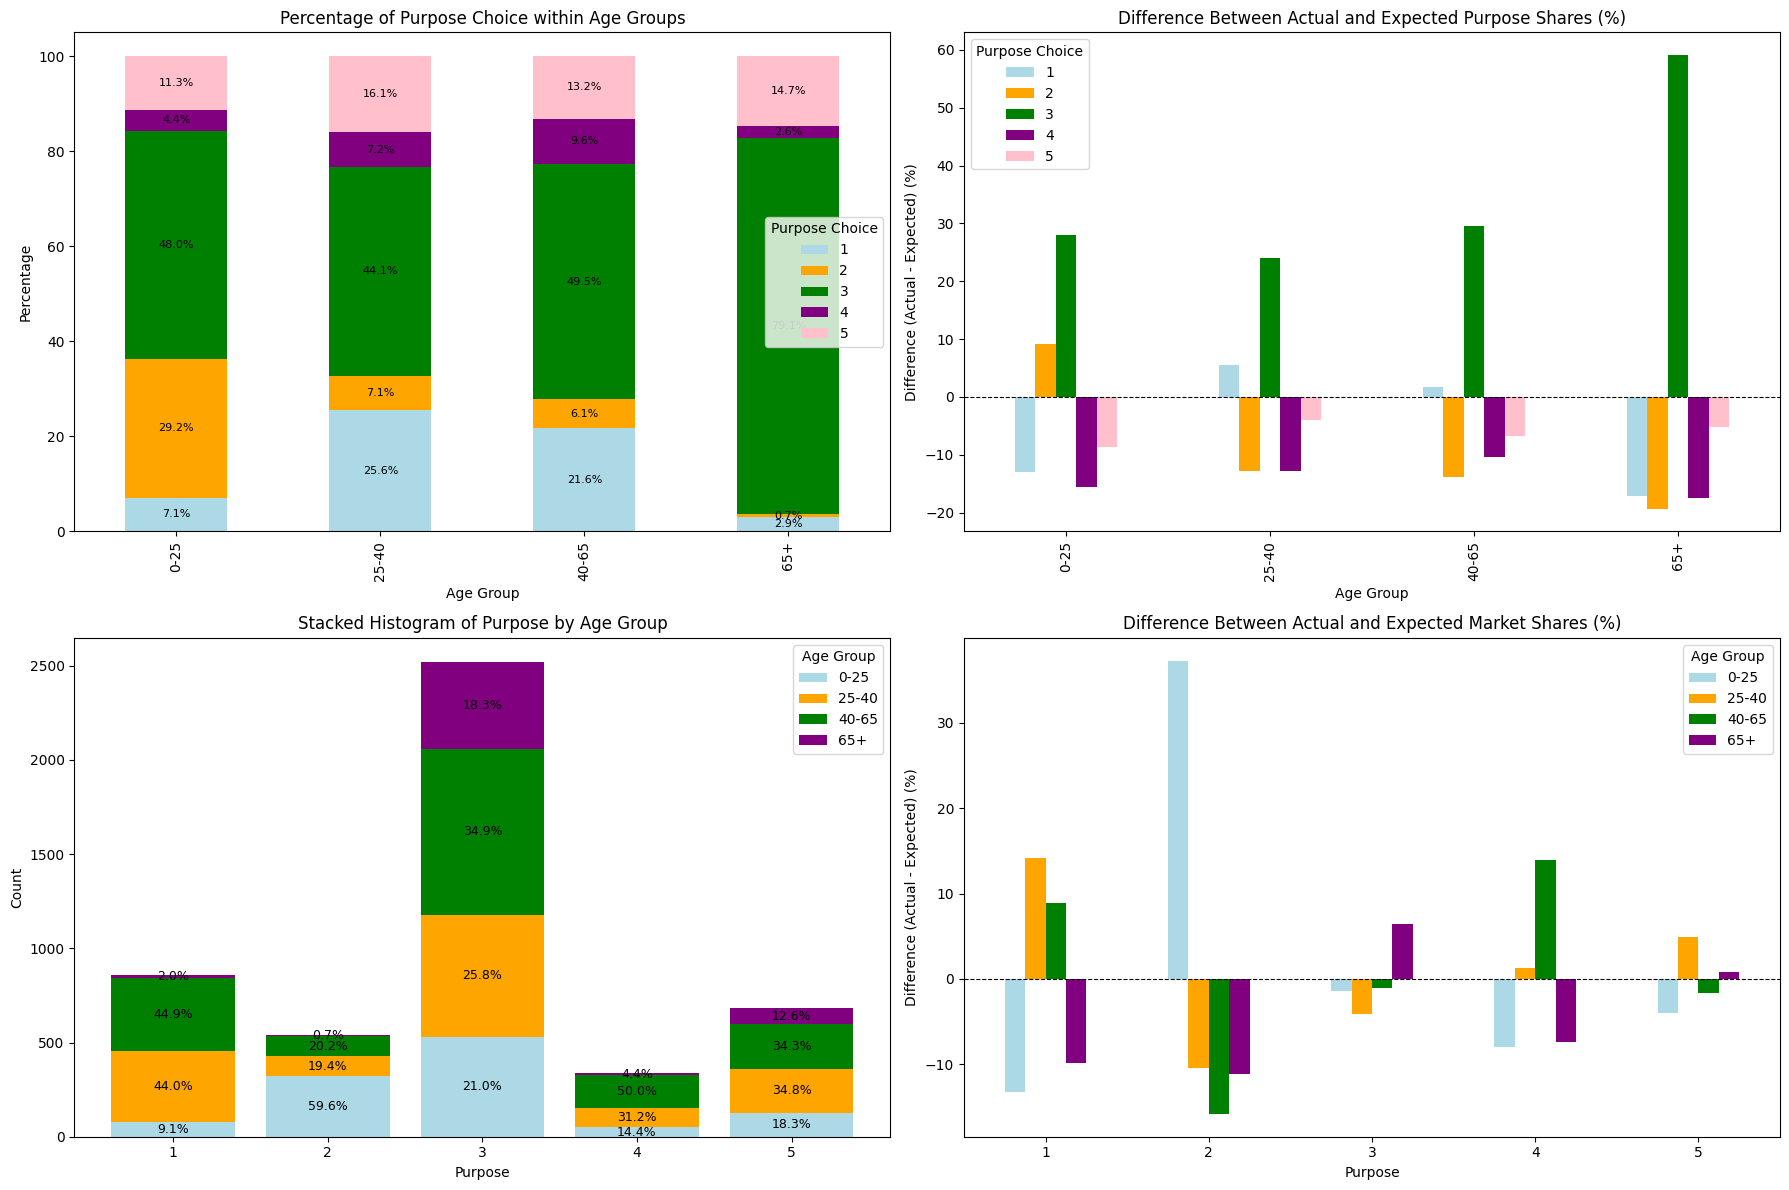

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Simulated or existing dataset
# Ensure your `data_filtered` DataFrame has the columns 'purpose' and 'travel_mode'

# Purpose ID mapping
purpose_mapping = {
    1: 'Home-based Work',
    2: 'Home-based Education',
    3: 'Home-based Other',
    4: 'Employer’s Business',
    5: 'Non-homebased Other'
}

# Replace purpose IDs with descriptive names
data_filtered['purpose_label'] = data_filtered['purpose'].map(purpose_mapping)

# Group by purpose_label and travel_mode, and count occurrences
counts = data_filtered.groupby(['purpose_label', 'travel_mode']).size().unstack(fill_value=0)

# Convert counts to percentages if needed
counts_percent = counts.div(counts.sum(axis=1), axis=0) * 100  # Uncomment this line for percentages

# Define consistent color palette for transportation modes
mode_colors = ['lightblue', 'orange', 'green', 'purple']  # Adjust to match your mode names

# Plot the stacked bar chart
ax = counts_percent.plot(kind='bar', stacked=True, color=mode_colors, figsize=(10, 6))  # Use counts_percent or counts
plt.xlabel('Purpose')
plt.ylabel('Percentage (%)' if 'counts_percent' in locals() else 'Count')
plt.title('Mode Choice by Purpose')

# Add legend for transportation modes
plt.legend(['Walk', 'Cycling', 'PT', 'Car'], title="Mode Choice", loc='upper right')

# Add percentage values centered in each segment if normalized
if 'counts_percent' in locals():
    for purpose in range(counts_percent.shape[0]):
        cumulative = 0
        for mode in range(counts_percent.shape[1]):
            percentage = counts_percent.iloc[purpose, mode]
            if percentage > 0:
                ax.text(purpose,
                        cumulative + percentage / 2,
                        f'{percentage:.1f}%',
                        ha='center', va='center', fontsize=8)
            cumulative += percentage

# Rotate x-tick labels for readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


C:\Users\mathi\AppData\Local\Temp\ipykernel_11632\2973874703.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['purpose_label'] = data_filtered['purpose'].map(purpose_mapping)


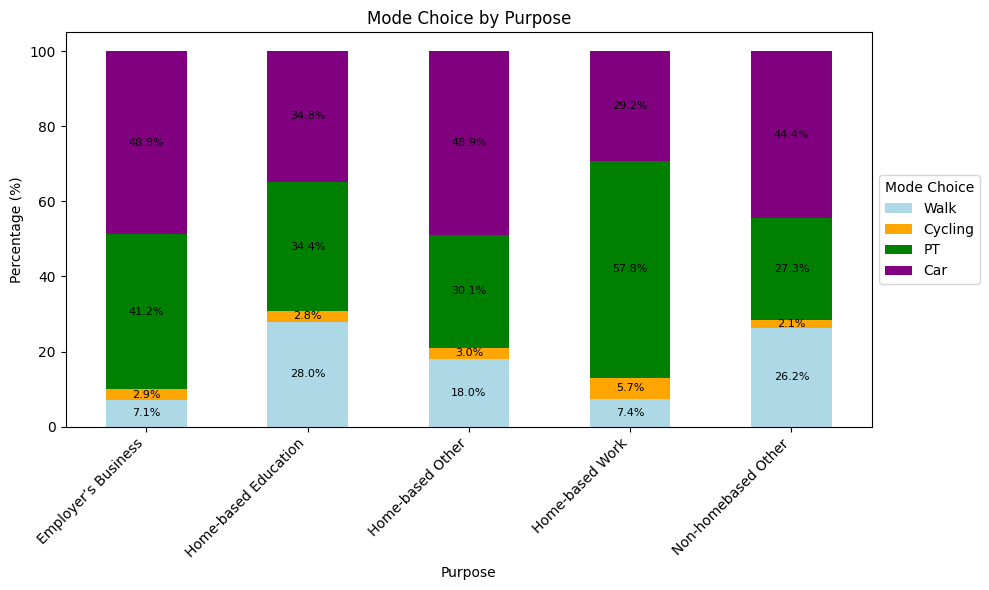

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Simulated or existing dataset
# Ensure your `data_filtered` DataFrame has the columns 'purpose' and 'travel_mode'

# Purpose ID mapping
purpose_mapping = {
    1: 'Home-based Work',
    2: 'Home-based Education',
    3: 'Home-based Other',
    4: 'Employer’s Business',
    5: 'Non-homebased Other'
}

# Replace purpose IDs with descriptive names
data_filtered['purpose_label'] = data_filtered['purpose'].map(purpose_mapping)

# Group by purpose_label and travel_mode, and count occurrences
counts = data_filtered.groupby(['purpose_label', 'travel_mode']).size().unstack(fill_value=0)

# Convert counts to percentages if needed
counts_percent = counts.div(counts.sum(axis=1), axis=0) * 100  # Uncomment this line for percentages

# Define consistent color palette for transportation modes
mode_colors = ['lightblue', 'orange', 'green', 'purple']  # Adjust to match your mode names

# Plot the stacked bar chart
ax = counts_percent.plot(kind='bar', stacked=True, color=mode_colors, figsize=(10, 6))  # Use counts_percent or counts
plt.xlabel('Purpose')
plt.ylabel('Percentage (%)' if 'counts_percent' in locals() else 'Count')
plt.title('Mode Choice by Purpose')

# Add legend for transportation modes and move it to the right
plt.legend(['Walk', 'Cycling', 'PT', 'Car'], title="Mode Choice", loc='center left', bbox_to_anchor=(1, 0.5))

# Add percentage values centered in each segment if normalized
if 'counts_percent' in locals():
    for purpose in range(counts_percent.shape[0]):
        cumulative = 0
        for mode in range(counts_percent.shape[1]):
            percentage = counts_percent.iloc[purpose, mode]
            if percentage > 0:
                ax.text(purpose,
                        cumulative + percentage / 2,
                        f'{percentage:.1f}%',
                        ha='center', va='center', fontsize=8)
            cumulative += percentage

# Rotate x-tick labels for readability
plt.xticks(rotation=45, ha='right')

# Adjust layout for legend placement
plt.tight_layout()

# Display the plot
plt.show()


C:\Users\mathi\AppData\Local\Temp\ipykernel_11632\3709342535.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['distance_group'] = pd.cut(data_filtered['distance'], bins=distance_bins, labels=distance_labels, right=False)
C:\Users\mathi\AppData\Local\Temp\ipykernel_11632\3709342535.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['purpose_label'] = data_filtered['purpose'].map(purpose_mapping)
C:\Users\mathi\AppData\Local\Temp\ipykernel_11632\3709342535.py:24: FutureWarnin

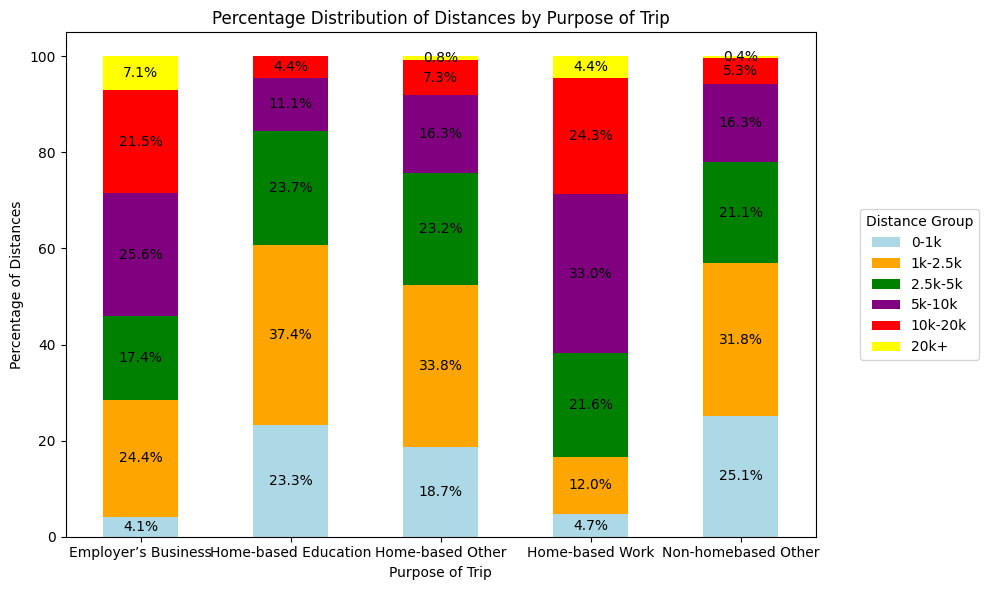

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Purpose mapping
purpose_mapping = {
    1: 'Home-based Work',
    2: 'Home-based Education',
    3: 'Home-based Other',
    4: 'Employer’s Business',
    5: 'Non-homebased Other'
}

# Define distance bins and labels
distance_bins = [0, 1000, 2500, 5000, 10000, 20000, float('inf')]
distance_labels = ['0-1k', '1k-2.5k', '2.5k-5k', '5k-10k', '10k-20k', '20k+']

# Ensure your `data_filtered` DataFrame has the 'distance' and 'purpose' columns
data_filtered['distance_group'] = pd.cut(data_filtered['distance'], bins=distance_bins, labels=distance_labels, right=False)

# Map the purpose column to its descriptive labels
data_filtered['purpose_label'] = data_filtered['purpose'].map(purpose_mapping)

# Group by purpose and distance group, then count occurrences
counts = data_filtered.groupby(['purpose_label', 'distance_group']).size().unstack(fill_value=0)

# Convert the counts to percentages
counts_percent = counts.div(counts.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart (now with percentages)
ax = counts_percent.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightblue', 'orange', 'green', 'purple', 'red', 'yellow'])

# Add labels and title
plt.xlabel('Purpose of Trip')
plt.ylabel('Percentage of Distances')
plt.title('Percentage Distribution of Distances by Purpose of Trip')

# Add legend to the right of the plot
plt.legend(distance_labels, title="Distance Group", bbox_to_anchor=(1.05, 0.5), loc='center left')

# Add percentage labels in the center of each stack
for p_idx in range(counts_percent.shape[0]):  # For each purpose
    cumulative = 0  # To track the cumulative height for each stacked bar
    for d_idx in range(counts_percent.shape[1]):  # For each distance group
        percentage = counts_percent.iloc[p_idx, d_idx]
        if percentage > 0:  # Only display if percentage is non-zero
            ax.text(p_idx, cumulative + percentage / 2, f'{percentage:.1f}%', ha='center', va='center', fontsize=10, color='black')
        cumulative += percentage  # Update cumulative position for the next stack

# Rotate x-tick labels for readability
plt.xticks(rotation=0)

# Adjust layout to prevent clipping of legend and labels
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
data_filtered['age_group'].value_counts()

age_group
40-65    1779
25-40    1475
0-25     1103
65+       584
Name: count, dtype: int64

C:\Users\mathi\AppData\Local\Temp\ipykernel_7776\197346996.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['age_group'] = pd.cut(data_filtered['age'], bins=age_bins, labels=age_labels, right=False)
C:\Users\mathi\AppData\Local\Temp\ipykernel_7776\197346996.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data_filtered.groupby(['age_group', 'travel_mode']).size().unstack(fill_value=0)


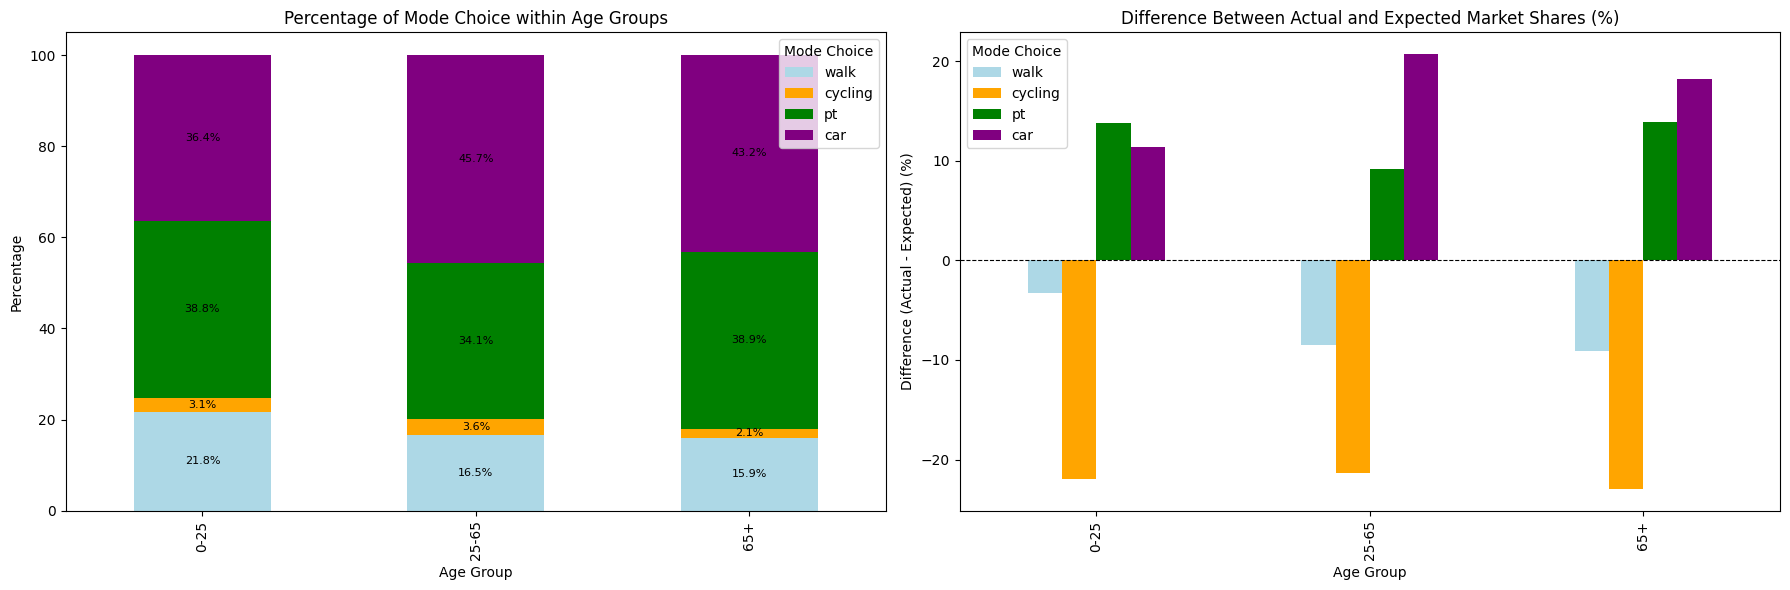

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulated or existing dataset
# Ensure your `data_filtered` DataFrame has the columns 'age' and 'travel_mode'

# Define age categories
age_bins = [0, 25, 65,float('inf')]
age_labels = ['0-25', '25-65', '65+']
data_filtered['age_group'] = pd.cut(data_filtered['age'], bins=age_bins, labels=age_labels, right=False)

# Group by age_group and travel_mode, then normalize to get percentages
counts = data_filtered.groupby(['age_group', 'travel_mode']).size().unstack(fill_value=0)
counts_percent = counts.div(counts.sum(axis=1), axis=0) * 100  # Convert to percentage

# Expected shares (25% for each mode across all age groups)
expected_shares = pd.DataFrame(
    np.full(counts_percent.shape, 25),  # 25% for each mode
    index=counts_percent.index,
    columns=counts_percent.columns
)

# Difference between actual and expected shares
differences = counts_percent - expected_shares

# Define consistent color palette for modes
mode_colors = ['lightblue', 'orange', 'green', 'purple']

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# First subplot: Stacked bar chart with percentages
ax1 = axes[0]
counts_percent.plot(kind='bar', stacked=True, color=mode_colors, ax=ax1)
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Percentage')
ax1.set_title('Percentage of Mode Choice within Age Groups')
ax1.legend(['walk', 'cycling', 'pt', 'car'], title="Mode Choice")

# Display percentage values centered in each segment
for age_group in range(counts_percent.shape[0]):  # Loop through age groups (x-axis positions)
    cumulative = 0  # Track cumulative percentage position for each segment
    for mode in range(counts_percent.shape[1]):  # Loop through modes (stack segments)
        percentage = counts_percent.iloc[age_group, mode]
        if percentage > 0:  # Only display if percentage is non-zero
            ax1.text(
                age_group,  # X-coordinate (age group position)
                cumulative + percentage / 2,  # Y-coordinate (center of the segment)
                f'{percentage:.1f}%',  # Text to display
                ha='center', va='center', fontsize=8, color='black'
            )
        cumulative += percentage  # Update cumulative position for the next segment

# Second subplot: Difference between actual and expected shares
ax2 = axes[1]
differences.plot(kind='bar', color=mode_colors, ax=ax2)
ax2.legend(['walk', 'cycling', 'pt', 'car'], title="Mode Choice")
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add baseline at y=0
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Difference (Actual - Expected) (%)')
ax2.set_title('Difference Between Actual and Expected Market Shares (%)')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


C:\Users\mathi\AppData\Local\Temp\ipykernel_7776\4039611171.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['age_group'] = pd.cut(data_filtered['age'], bins=age_bins, labels=age_labels, right=False)
C:\Users\mathi\AppData\Local\Temp\ipykernel_7776\4039611171.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distance_stats = data_filtered.groupby('age_group')['distance'].agg(['mean', 'std'])


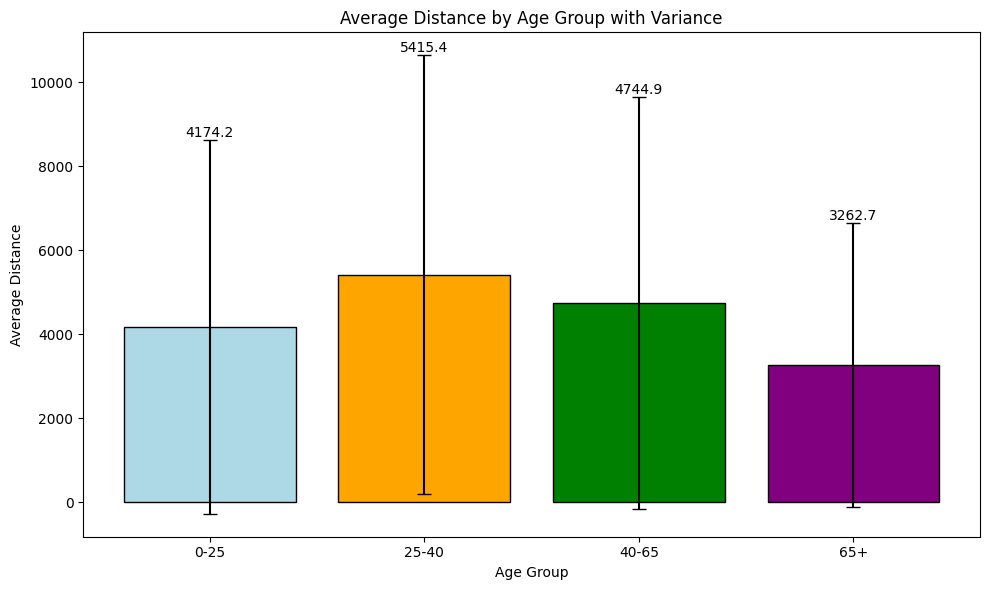

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define age categories
age_bins = [0, 25, 40, 65, float('inf')]
age_labels = ['0-25', '25-40', '40-65', '65+']
data_filtered['age_group'] = pd.cut(data_filtered['age'], bins=age_bins, labels=age_labels, right=False)

# Calculate mean and standard deviation of distances by age group
distance_stats = data_filtered.groupby('age_group')['distance'].agg(['mean', 'std'])

# Extract means and standard deviations
average_distances = distance_stats['mean']
std_deviations = distance_stats['std']

# Define consistent color palette for age groups
age_colors = ['lightblue', 'orange', 'green', 'purple']

# Plot the bar chart for average distances with error bars
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(average_distances.index, average_distances, yerr=std_deviations, color=age_colors, capsize=5, edgecolor='black')

# Add labels and title
plt.xlabel('Age Group')
plt.ylabel('Average Distance')
plt.title('Average Distance by Age Group with Variance')

# Annotate bars with average values
for i, (avg_dist, std_dev) in enumerate(zip(average_distances, std_deviations)):
    ax.text(i, avg_dist + std_dev + 0.5, f'{avg_dist:.1f}', ha='center', va='bottom', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


C:\Users\mathi\AppData\Local\Temp\ipykernel_7776\4113151878.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['distance_group'] = pd.cut(data_filtered['distance'], bins=distance_bins, labels=distance_labels, right=False)
C:\Users\mathi\AppData\Local\Temp\ipykernel_7776\4113151878.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['age_group'] = pd.cut(data_filtered['age'], bins=age_bins, labels=age_labels, right=False)
C:\Users\mathi\AppData\Local\Temp\ipykernel_7776\41131518

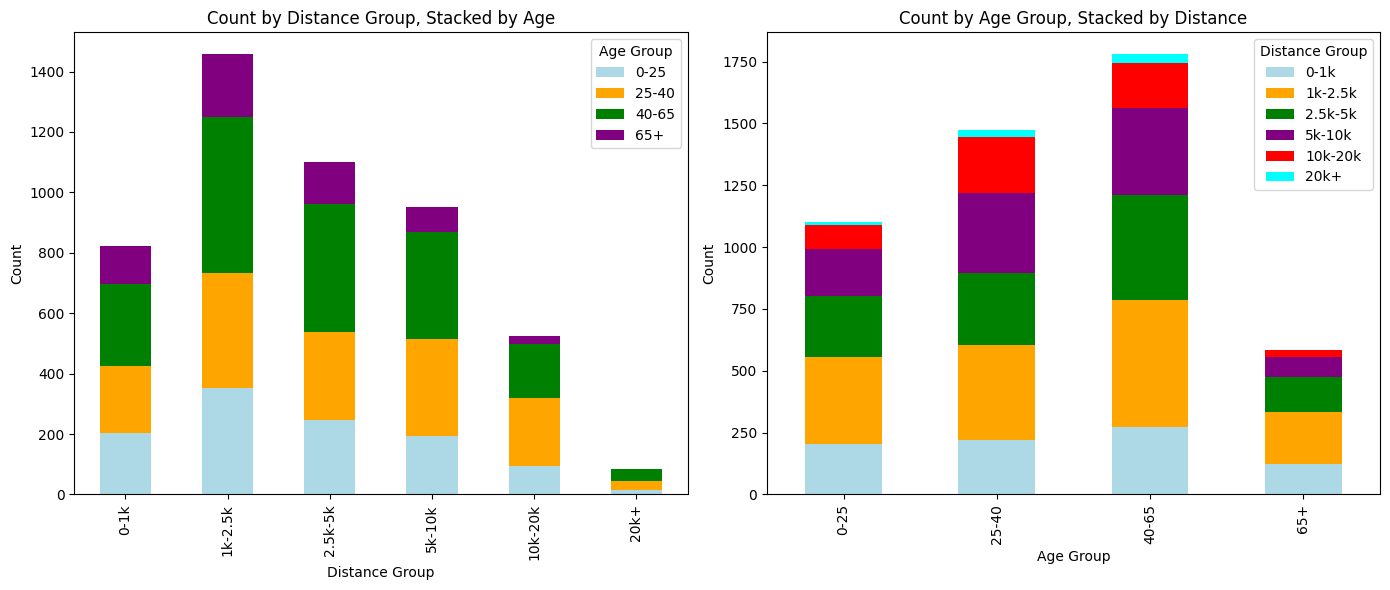

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Define distance and age bins
distance_bins = [0, 1000, 2500, 5000, 10000, 20000, float('inf')]
distance_labels = ['0-1k', '1k-2.5k', '2.5k-5k', '5k-10k', '10k-20k', '20k+']
data_filtered['distance_group'] = pd.cut(data_filtered['distance'], bins=distance_bins, labels=distance_labels, right=False)

age_bins = [0, 25, 40, 65, float('inf')]
age_labels = ['0-25', '25-40', '40-65', '65+']
data_filtered['age_group'] = pd.cut(data_filtered['age'], bins=age_bins, labels=age_labels, right=False)

# Plot settings
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot: Stacked by age with distance as x-axis
distance_age_counts = data_filtered.groupby(['distance_group', 'age_group']).size().unstack(fill_value=0)
distance_age_counts.plot(kind='bar', stacked=True, color=['lightblue', 'orange', 'green', 'purple'], ax=axes[0])
axes[0].set_xlabel('Distance Group')
axes[0].set_ylabel('Count')
axes[0].set_title('Count by Distance Group, Stacked by Age')
axes[0].legend(title='Age Group')

# Second plot: Stacked by distance with age as x-axis
age_distance_counts = data_filtered.groupby(['age_group', 'distance_group']).size().unstack(fill_value=0)
age_distance_counts.plot(kind='bar', stacked=True, color=['lightblue', 'orange', 'green', 'purple', 'red', 'cyan'], ax=axes[1])
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Count')
axes[1].set_title('Count by Age Group, Stacked by Distance')
axes[1].legend(title='Distance Group')

# Adjust layout and show
plt.tight_layout()
plt.show()


C:\Users\mathi\AppData\Local\Temp\ipykernel_7776\955435462.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['distance_group'] = pd.cut(data_filtered['distance'], bins=distance_bins, labels=distance_labels, right=False)
C:\Users\mathi\AppData\Local\Temp\ipykernel_7776\955435462.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['age_group'] = pd.cut(data_filtered['age'], bins=age_bins, labels=age_labels, right=False)
C:\Users\mathi\AppData\Local\Temp\ipykernel_7776\955435462.p

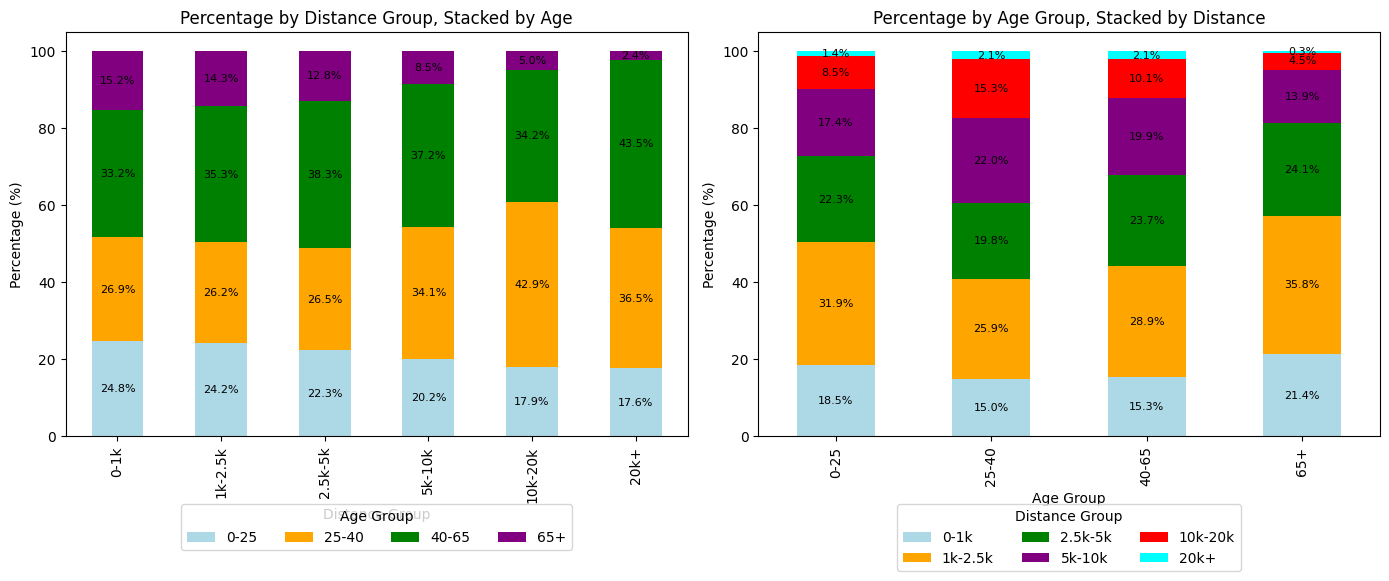

In [ ]:
# Define distance and age bins
distance_bins = [0, 1000, 2500, 5000, 10000, 20000, float('inf')]
distance_labels = ['0-1k', '1k-2.5k', '2.5k-5k', '5k-10k', '10k-20k', '20k+']
data_filtered['distance_group'] = pd.cut(data_filtered['distance'], bins=distance_bins, labels=distance_labels, right=False)

age_bins = [0, 25, 40, 65, float('inf')]
age_labels = ['0-25', '25-40', '40-65', '65+']
data_filtered['age_group'] = pd.cut(data_filtered['age'], bins=age_bins, labels=age_labels, right=False)

# Calculate percentage counts
distance_age_counts = data_filtered.groupby(['distance_group', 'age_group']).size().unstack(fill_value=0)
distance_age_percent = distance_age_counts.div(distance_age_counts.sum(axis=1), axis=0) * 100

age_distance_counts = data_filtered.groupby(['age_group', 'distance_group']).size().unstack(fill_value=0)
age_distance_percent = age_distance_counts.div(age_distance_counts.sum(axis=1), axis=0) * 100

# Plot settings
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot: Stacked by age with distance as x-axis (percentages)
distance_age_percent.plot(kind='bar', stacked=True, color=['lightblue', 'orange', 'green', 'purple'], ax=axes[0])
axes[0].set_xlabel('Distance Group')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Percentage by Distance Group, Stacked by Age')
axes[0].legend(title='Age Group', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4)

# Add percentage labels to the first plot
for i in range(distance_age_percent.shape[0]):
    cumulative = 0
    for j in range(distance_age_percent.shape[1]):
        percent = distance_age_percent.iloc[i, j]
        if percent > 0:
            axes[0].text(i, cumulative + percent / 2, f'{percent:.1f}%', ha='center', va='center', fontsize=8)
        cumulative += percent

# Second plot: Stacked by distance with age as x-axis (percentages)
age_distance_percent.plot(kind='bar', stacked=True, color=['lightblue', 'orange', 'green', 'purple', 'red', 'cyan'], ax=axes[1])
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_title('Percentage by Age Group, Stacked by Distance')
axes[1].legend(title='Distance Group', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)

# Add percentage labels to the second plot
for i in range(age_distance_percent.shape[0]):
    cumulative = 0
    for j in range(age_distance_percent.shape[1]):
        percent = age_distance_percent.iloc[i, j]
        if percent > 0:
            axes[1].text(i, cumulative + percent / 2, f'{percent:.1f}%', ha='center', va='center', fontsize=8)
        cumulative += percent

# Adjust layout and show
plt.tight_layout()
plt.show()


C:\Users\mathi\AppData\Local\Temp\ipykernel_7776\2342075928.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['distance_group'] = pd.cut(data_filtered['distance'], bins=distance_bins, labels=distance_labels, right=False)
C:\Users\mathi\AppData\Local\Temp\ipykernel_7776\2342075928.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['travel_mode_label'] = data_filtered['travel_mode'].map(mode_mapping)
C:\Users\mathi\AppData\Local\Temp\ipykernel_7776\2342075928.py:11: FutureWarnin

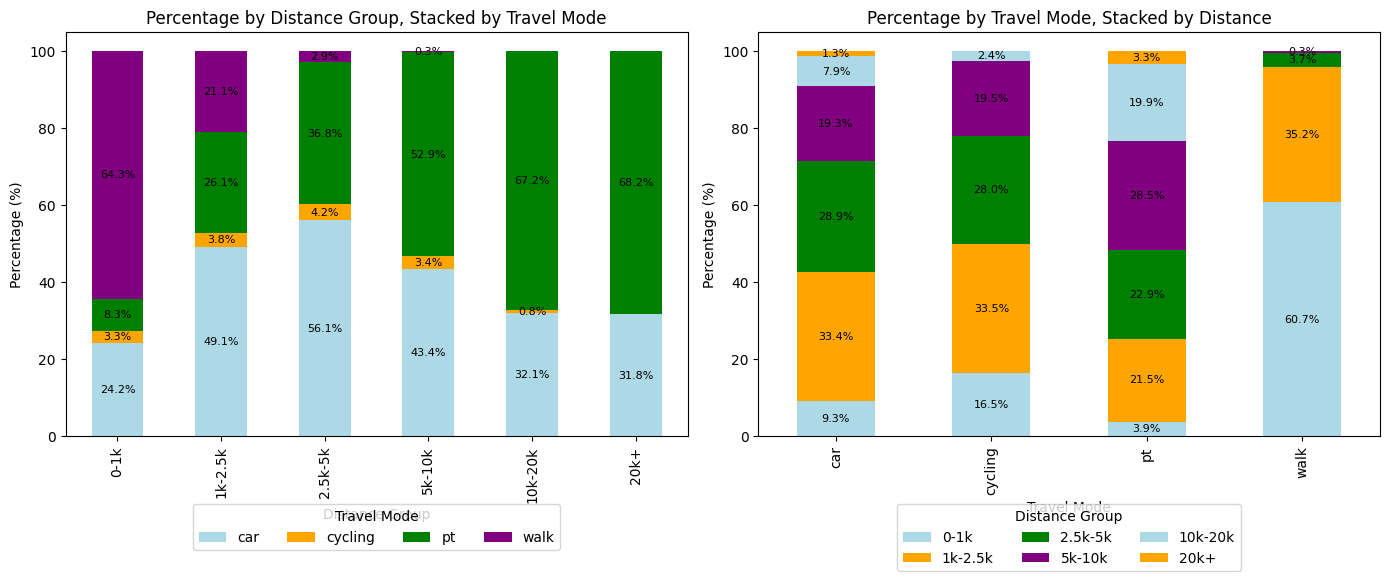

In [ ]:
# Define distance bins and labels
distance_bins = [0, 1000, 2500, 5000, 10000, 20000, float('inf')]
distance_labels = ['0-1k', '1k-2.5k', '2.5k-5k', '5k-10k', '10k-20k', '20k+']
data_filtered['distance_group'] = pd.cut(data_filtered['distance'], bins=distance_bins, labels=distance_labels, right=False)

# Map numerical travel_mode [0,1,2,3] to ['walk', 'cycling', 'pt', 'car']
mode_mapping = {1: 'walk', 2: 'cycling', 3: 'pt', 4: 'car'}
data_filtered['travel_mode_label'] = data_filtered['travel_mode'].map(mode_mapping)

# Calculate percentage counts for distance and travel_mode
distance_choice_counts = data_filtered.groupby(['distance_group', 'travel_mode_label']).size().unstack(fill_value=0)
distance_choice_percent = distance_choice_counts.div(distance_choice_counts.sum(axis=1), axis=0) * 100

# Calculate percentage counts for travel_mode and distance (inverse)
choice_distance_counts = data_filtered.groupby(['travel_mode_label', 'distance_group']).size().unstack(fill_value=0)
choice_distance_percent = choice_distance_counts.div(choice_distance_counts.sum(axis=1), axis=0) * 100

# Plot settings
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot: Stacked by travel_mode with distance as x-axis (percentages)
distance_choice_percent.plot(kind='bar', stacked=True, color=['lightblue', 'orange', 'green', 'purple'], ax=axes[0])
axes[0].set_xlabel('Distance Group')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Percentage by Distance Group, Stacked by Travel Mode')
axes[0].legend(title='Travel Mode', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4)

# Add percentage labels to the first plot
for i in range(distance_choice_percent.shape[0]):
    cumulative = 0
    for j in range(distance_choice_percent.shape[1]):
        percent = distance_choice_percent.iloc[i, j]
        if percent > 0:
            axes[0].text(i, cumulative + percent / 2, f'{percent:.1f}%', ha='center', va='center', fontsize=8)
        cumulative += percent

# Second plot: Stacked by distance with travel_mode as x-axis (percentages)
choice_distance_percent.plot(kind='bar', stacked=True, color=['lightblue', 'orange', 'green', 'purple'], ax=axes[1])
axes[1].set_xlabel('Travel Mode')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_title('Percentage by Travel Mode, Stacked by Distance')
axes[1].legend(title='Distance Group', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)

# Add percentage labels to the second plot
for i in range(choice_distance_percent.shape[0]):
    cumulative = 0
    for j in range(choice_distance_percent.shape[1]):
        percent = choice_distance_percent.iloc[i, j]
        if percent > 0:
            axes[1].text(i, cumulative + percent / 2, f'{percent:.1f}%', ha='center', va='center', fontsize=8)
        cumulative += percent

# Adjust layout and show
plt.tight_layout()
plt.show()


C:\Users\mathi\AppData\Local\Temp\ipykernel_7776\3040714714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['time_pt'] = data_filtered['dur_pt_access'] + data_filtered['dur_pt_rail'] + data_filtered['dur_pt_bus'] + data_filtered['dur_pt_int']
C:\Users\mathi\AppData\Local\Temp\ipykernel_7776\3040714714.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['time_cycling'] = data_filtered['dur_cycling']
C:\Users\mathi\AppData\Local\Temp\ipykernel_7776\3040714714.py:4: SettingWithC

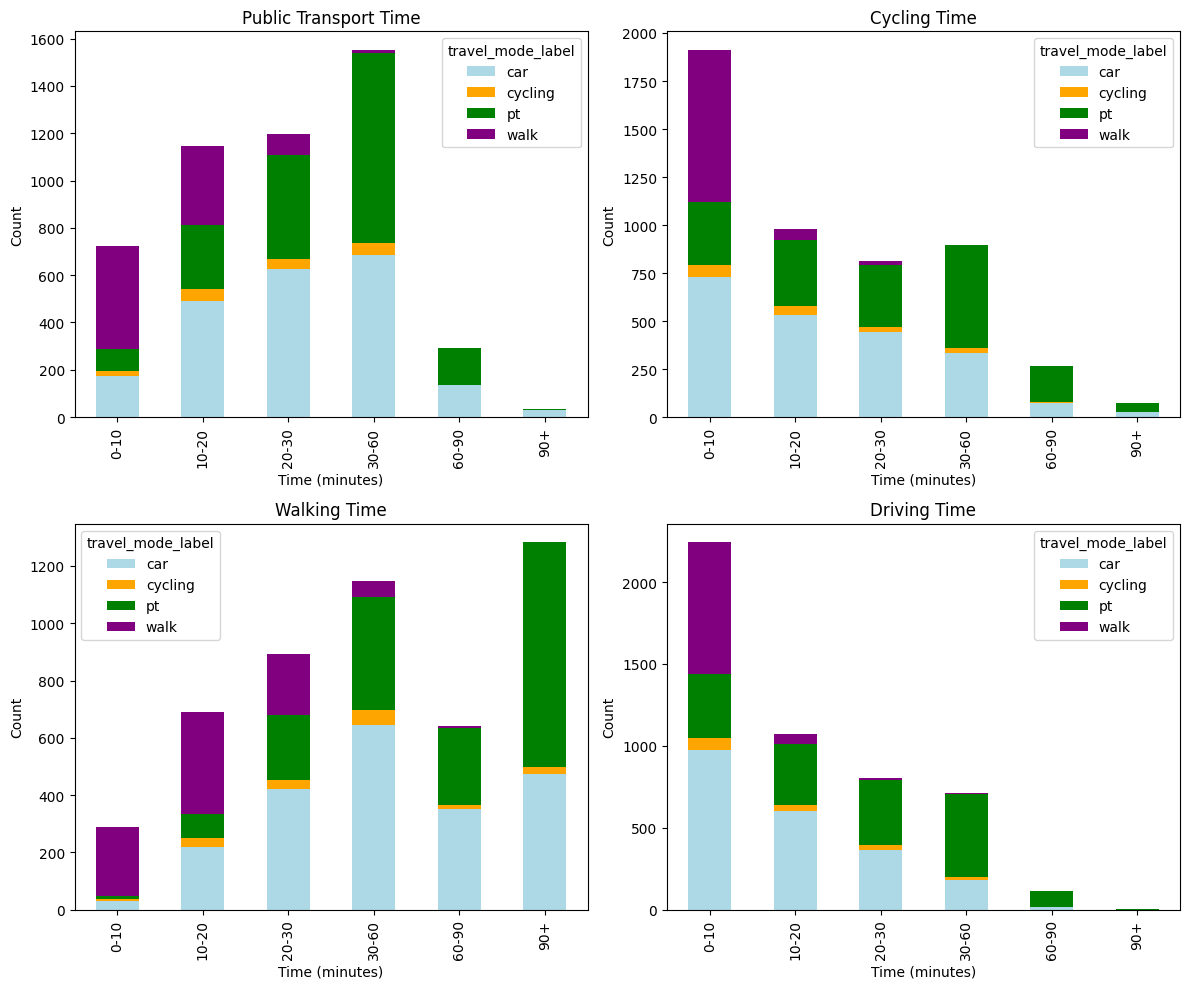

In [ ]:
# Define time variables for each transport mode
data_filtered['time_pt'] = data_filtered['dur_pt_access'] + data_filtered['dur_pt_rail'] + data_filtered['dur_pt_bus'] + data_filtered['dur_pt_int']
data_filtered['time_cycling'] = data_filtered['dur_cycling']
data_filtered['time_walking'] = data_filtered['dur_walking']
data_filtered['time_driving'] = data_filtered['dur_driving']

mode_mapping = {1: 'walk', 2: 'cycling', 3: 'pt', 4: 'car'}
data_filtered['travel_mode_label'] = data_filtered['travel_mode'].map(mode_mapping)

# Create bins for time (in minutes)
time_bins = [0, 0.17, 0.3, 0.5, 1, 1.5, float('inf')]  # Define custom time bins
time_labels = ['0-10', '10-20', '20-30', '30-60', '60-90', '90+']

# Apply bins to each time column
data_filtered['time_pt_binned'] = pd.cut(data_filtered['time_pt'], bins=time_bins, labels=time_labels, right=False)
data_filtered['time_cycling_binned'] = pd.cut(data_filtered['time_cycling'], bins=time_bins, labels=time_labels, right=False)
data_filtered['time_walking_binned'] = pd.cut(data_filtered['time_walking'], bins=time_bins, labels=time_labels, right=False)
data_filtered['time_driving_binned'] = pd.cut(data_filtered['time_driving'], bins=time_bins, labels=time_labels, right=False)

# Set up subplots (4 histograms)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Define the time columns for plotting
time_columns = ['time_pt_binned', 'time_cycling_binned', 'time_walking_binned', 'time_driving_binned']
titles = ['Public Transport Time', 'Cycling Time', 'Walking Time', 'Driving Time']

# Plot each histogram
for i, time_column in enumerate(time_columns):
    ax = axes[i // 2, i % 2]  # Get the appropriate axis for the subplot
    # Group data by travel mode and binned time, then calculate the counts for each time range
    counts = data_filtered.groupby([time_column,'travel_mode_label']).size().unstack(fill_value=0)
    
    # Plot the stacked histogram
    counts.plot(kind='bar', stacked=True, ax=ax, color=['lightblue', 'orange', 'green', 'purple'])
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Count')
    ax.set_title(titles[i])
    
    # # Add percentage labels inside the bars
    # for p in ax.patches:
    #     height = p.get_height()
    #     width = p.get_width()
    #     x = p.get_x() + width / 2
    #     y = p.get_y() + height / 2
    #     percentage = (height / counts.sum().sum()) * 100  # Percentage based on total count
    #     ax.text(x, y, f'{percentage:.1f}%', ha='center', va='center', fontsize=8)

# Adjust layout and show
plt.tight_layout()
plt.show()


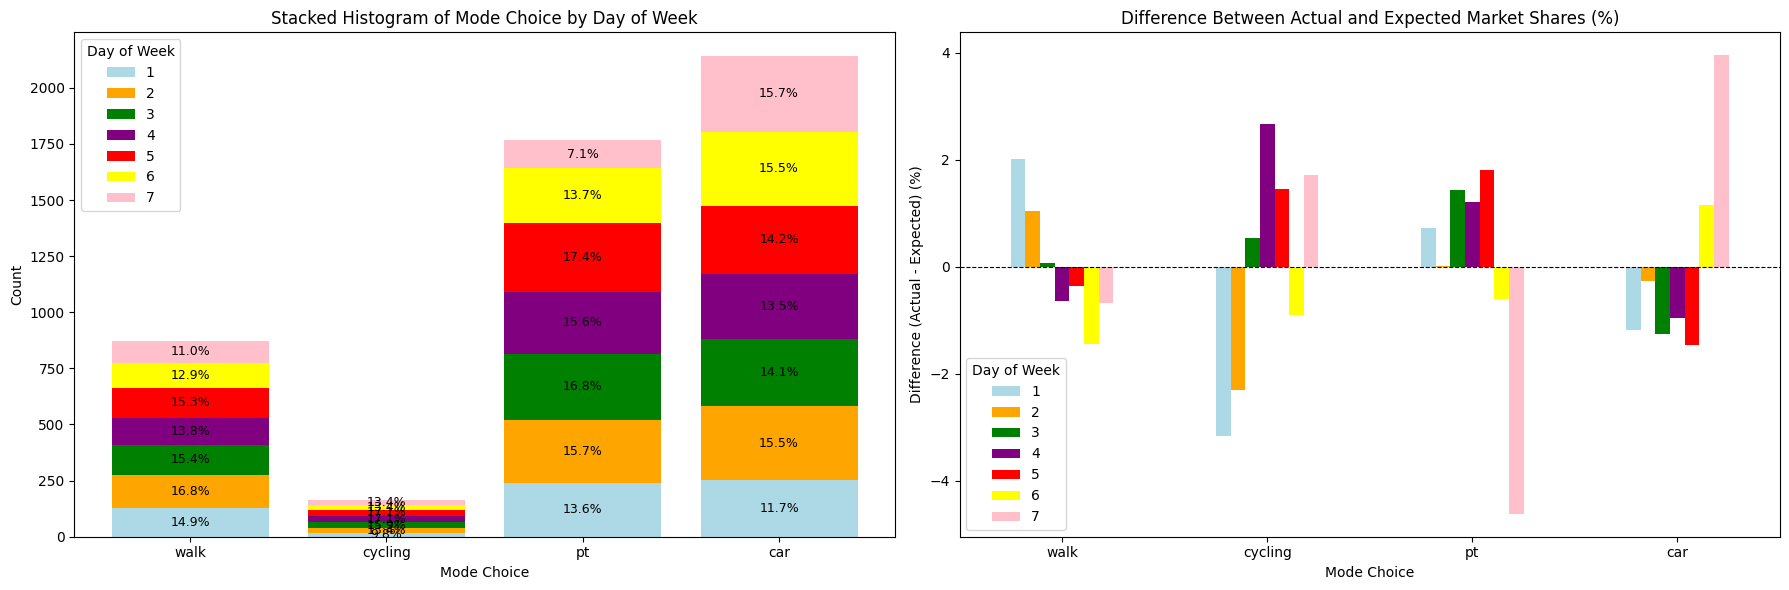

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulated or existing dataset
# Ensure your `data_filtered` DataFrame has the columns 'day_of_week' and 'travel_mode'

# Group by travel mode and day of the week
counts = data_filtered.groupby(['travel_mode', 'day_of_week']).size().unstack(fill_value=0)

# Define consistent color palette for days of the week
day_colors = ['lightblue', 'orange', 'green', 'purple', 'red', 'yellow', 'pink']  # Colors for each day

# Compute the total population per day of the week
day_totals = data_filtered['day_of_week'].value_counts(sort=False)

# Compute the weights for each day of the week
day_weights = day_totals / day_totals.sum()

# Compute actual shares
total_counts = counts.sum(axis=1)
actual_shares = counts.div(total_counts, axis=0)

# Compute expected shares based on day of the week weights
expected_shares = pd.DataFrame(
    {day: day_weights[day] for day in counts.columns},
    index=counts.index
)

# Compute differences
differences = (actual_shares - expected_shares) * 100

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

mode_choices = ['walk', 'cycling', 'pt', 'car']  # Adjust this to match your mode choices

# First subplot: Stacked bar chart for day of the week
ax1 = axes[0]
bar_positions = np.arange(len(mode_choices))
bar_width = 0.8

# Plot stacked bar chart and add market share annotations
cumulative_bottom = np.zeros(len(mode_choices))

# Iterate over the days of the week
for idx, day in enumerate(sorted(data_filtered['day_of_week'].unique())):
    heights = counts[day]
    ax1.bar(bar_positions, heights, bottom=cumulative_bottom, color=day_colors[idx], label=day, width=bar_width)
    
    # Add market share annotations centered in each stack
    for i, (bottom, height) in enumerate(zip(cumulative_bottom, heights)):
        if height > 0:  # Only annotate non-zero stacks
            market_share = f"{(actual_shares.iloc[i, idx] * 100):.1f}%"
            ax1.text(
                i,  # x-position
                bottom + height / 2,  # y-position
                market_share,  # text
                ha='center', va='center', fontsize=9, color='black'
            )
    cumulative_bottom += heights

ax1.set_xlabel('Mode Choice')
ax1.set_ylabel('Count')
ax1.set_title('Stacked Histogram of Mode Choice by Day of Week')
ax1.legend(title="Day of Week")
ax1.set_xticks(bar_positions)
ax1.set_xticklabels(mode_choices, rotation=0)

# Second subplot: Difference between actual and expected market shares for days of the week
ax2 = axes[1]
differences.plot(kind='bar', color=day_colors, ax=ax2)
ax2.legend(sorted(data_filtered['day_of_week'].unique()), title="Day of Week")
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add baseline at y=0
ax2.set_xlabel('Mode Choice')
ax2.set_ylabel('Difference (Actual - Expected) (%)')
ax2.set_title('Difference Between Actual and Expected Market Shares (%)')
ax2.set_xticks(range(len(mode_choices)))
ax2.set_xticklabels(mode_choices, rotation=0)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


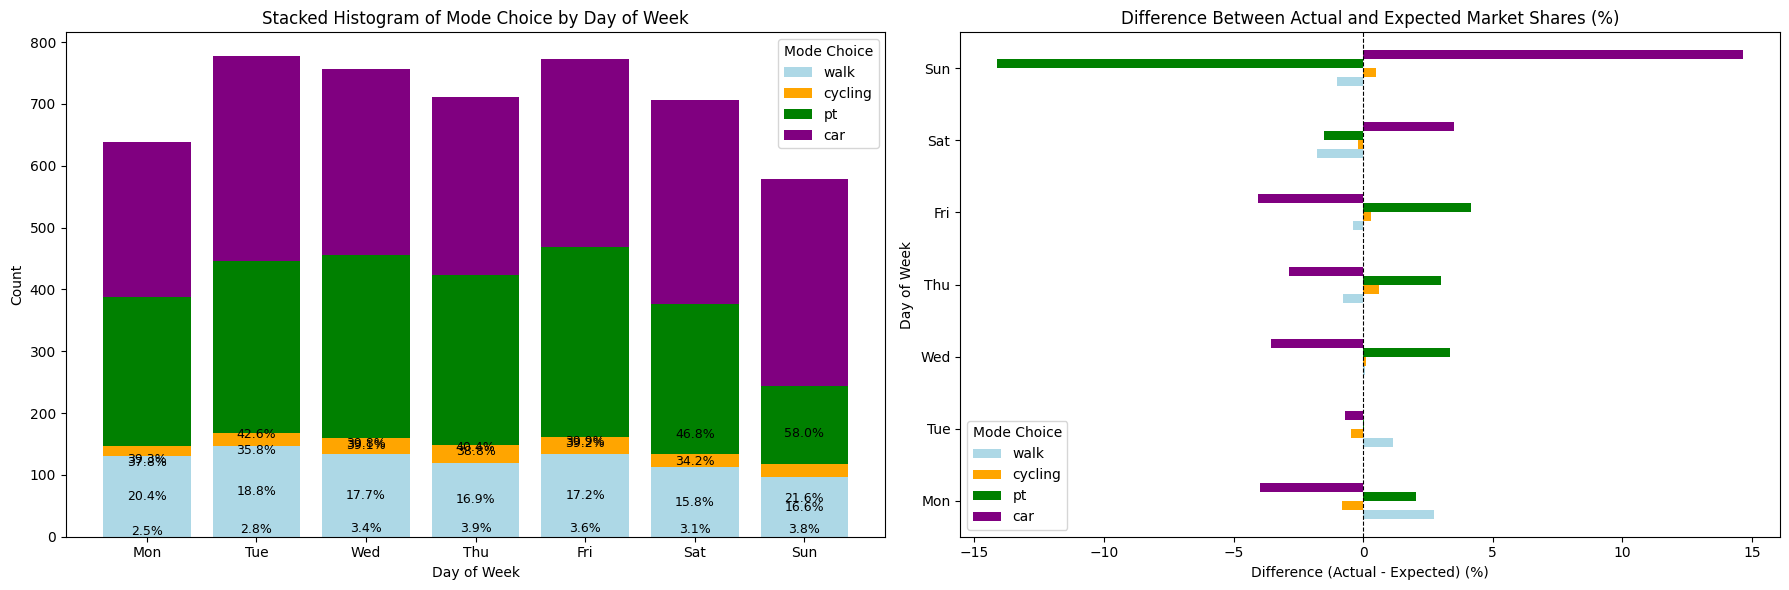

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulated or existing dataset
# Ensure your `data_filtered` DataFrame has the columns 'day_of_week' and 'travel_mode'

# Group by day of the week and travel mode
counts = data_filtered.groupby(['day_of_week', 'travel_mode']).size().unstack(fill_value=0)

# Define consistent color palette for mode choices
mode_colors = ['lightblue', 'orange', 'green', 'purple']  # Adjust according to your modes
mode_labels = ['walk', 'cycling', 'pt', 'car']  # Explicit mode names

# Compute the total population per day of the week
day_totals = data_filtered['day_of_week'].value_counts(sort=False)

# Compute actual shares for each mode for each day of the week
total_counts = counts.sum(axis=1)
actual_shares = counts.div(total_counts, axis=0)

# Compute expected shares based on mode distribution
mode_totals = data_filtered['travel_mode'].value_counts(sort=False)
mode_weights = mode_totals / mode_totals.sum()
expected_shares = pd.DataFrame(
    {mode: mode_weights[mode] for mode in counts.columns},
    index=counts.index
)

# Compute differences between actual and expected market shares
differences = (actual_shares - expected_shares) * 100

# Create the figure and axes for the plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# First subplot: Stacked bar chart for each day of the week
ax1 = axes[0]
cumulative_bottom = np.zeros(len(counts))

# Plot stacked bar chart for each day of the week
for idx, mode in enumerate(counts.columns):
    heights = counts[mode]
    ax1.bar(counts.index, heights, bottom=cumulative_bottom, color=mode_colors[idx], label=mode_labels[idx], width=0.8)
    
    # Update the cumulative bottom for the next stack
    cumulative_bottom += heights

# Add annotations (percentage shares) on the stacked bars
for idx, mode in enumerate(counts.columns):
    cumulative_bottom = np.zeros(len(counts))  # Reset the cumulative bottom for each mode
    for i, (bottom, height) in enumerate(zip(cumulative_bottom, counts[mode])):
        if height > 0:  # Only annotate non-zero stacks
            market_share = f"{(actual_shares.iloc[i, idx] * 100):.1f}%"
            # Calculate the bottom of the annotation by adding the height of all previous modes
            annotation_position = cumulative_bottom[i] + height / 2
            ax1.text(
                counts.index[i],  # x-position (day of the week)
                annotation_position,  # y-position (centered in the mode stack)
                market_share,  # text
                ha='center', va='center', fontsize=9, color='black'
            )
        cumulative_bottom[i] += height  # Update cumulative bottom for correct annotation placement

# Set labels and title for the first plot
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Count')
ax1.set_title('Stacked Histogram of Mode Choice by Day of Week')
ax1.legend(title="Mode Choice")
ax1.set_xticks(np.arange(1, 8))  # Days of the week 1-7
ax1.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Second subplot: Difference between actual and expected market shares for days of the week
ax2 = axes[1]
differences.plot(kind='barh', color=mode_colors, ax=ax2)

# Labels and titles for the second plot
ax2.legend(mode_labels, title="Mode Choice")
ax2.axvline(0, color='black', linewidth=0.8, linestyle='--')  # Add baseline at x=0
ax2.set_xlabel('Difference (Actual - Expected) (%)')
ax2.set_ylabel('Day of Week')
ax2.set_title('Difference Between Actual and Expected Market Shares (%)')
ax2.set_yticks(range(len(counts.index)))
ax2.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [ ]:
trip_id = Variable('trip_id')
household_id = Variable('household_id')
person_n = Variable('person_n')
trip_n = Variable('trip_n')
travel_mode = Variable('travel_mode')
purpose = Variable('purpose')
fueltype = Variable('fueltype')
faretype = Variable('faretype')
bus_scale = Variable('bus_scale')
survey_year = Variable('survey_year')
travel_year = Variable('travel_year')
travel_month = Variable('travel_month')
travel_date = Variable('travel_date')
day_of_week = Variable('day_of_week')
start_time = Variable('start_time')
age = Variable('age')
female = Variable('female')
driving_license = Variable('driving_license')
car_ownership = Variable('car_ownership')
distance = Variable('distance')
dur_walking = Variable('dur_walking')
dur_cycling = Variable('dur_cycling')
dur_pt_access = Variable('dur_pt_access') # Predicted total access and egress time for public transport route in hours
dur_pt_rail = Variable('dur_pt_rail')
dur_pt_bus = Variable('dur_pt_bus')
dur_pt_int = Variable('dur_pt_int') # Time taken (hrs) at each interchange point
pt_interchanges = Variable('pt_interchanges')   # Number of interchange points in public transport route
dur_driving = Variable('dur_driving')
cost_transit = Variable('cost_transit')
cost_driving_fuel = Variable('cost_driving_fuel')   # Estimated fuel cost of driving route in GBP
cost_driving_ccharge = Variable('cost_driving_ccharge')  # Estimated congestion charge cost of driving route in GBP
driving_traffic_percent = Variable('driving_traffic_percent')

household_has_license = Variable('household_has_license')


In [ ]:
# Define driving cost
cost_driving = cost_driving_ccharge + cost_driving_fuel

# Define time taken by each mode of transport
time_pt = dur_pt_access + dur_pt_rail + dur_pt_bus + dur_pt_int 

time_cycling = dur_cycling
time_walking = dur_walking
time_driving = dur_driving

In [ ]:
# Define ASCs 
asc_car = Beta(name='asc_car', value=0, lowerbound=None, upperbound=None, status=0)
asc_walk = Beta(name='asc_walk', value=0, lowerbound=None, upperbound=None, status=0)
asc_pt = Beta(name='asc_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define generic parameters

beta_cost = Beta(name='beta_cost', value=0, lowerbound=None, upperbound=None, status=0)
beta_time = Beta(name='beta_time', value=0, lowerbound=None, upperbound=None, status=0)


In [ ]:
# Define utility functions

v_car = asc_car + beta_cost * cost_driving + beta_time * time_driving

v_walk = asc_walk + beta_time * time_walking

v_pt = asc_pt + beta_cost * cost_transit + beta_time * time_pt

v_cycling = beta_time * time_cycling

In [ ]:
# Availability

V = {1: v_walk, 2: v_cycling, 3: v_pt, 4: v_car}

CAR_AV = (car_ownership != 0) | (driving_license != 0) | (household_has_license != 0)
WALK_AV = (car_ownership >= 0)
PT_AV = (car_ownership >= 0)
CYCLING_AV = (car_ownership >= 0)

av = {1: WALK_AV, 2: CYCLING_AV , 3: PT_AV, 4: CAR_AV}

In [ ]:
logprob_m0 = loglogit(V, av, travel_mode)

model_0 = bio.BIOGEME(database, logprob_m0)
model_0.modelName = 'model_0'

null_log_likelihood_m0 = model_0.calculate_null_loglikelihood(av)

results_m0 = model_0.estimate()

print(results_m0.print_general_statistics())

TypeError: Cannot interpret 'CategoricalDtype(categories=['0-25', '25-40', '40-65', '65+'], ordered=True, categories_dtype=object)' as a data type

In [ ]:
pd_results_m0 = results_m0.get_estimated_parameters()
display(pd_results_m0)


,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_car,2.904088,0.091323,31.800297,0.0
asc_pt,3.355414,0.094523,35.498546,0.0
asc_walk,3.945274,0.112873,34.953192,0.0
beta_cost,-0.206632,0.015116,-13.669511,0.0
beta_time,-5.974888,0.227355,-26.280001,0.0


In [ ]:
# Define ASCs 
asc_car = Beta(name='asc_car', value=0, lowerbound=None, upperbound=None, status=0)
asc_walk = Beta(name='asc_walk', value=0, lowerbound=None, upperbound=None, status=0)
asc_pt = Beta(name='asc_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define generic parameters

beta_time = Beta(name='beta_time', value=0, lowerbound=None, upperbound=None, status=0)

# Define alternative specific parameters

beta_cost_car = Beta(name='beta_cost_car', value=0, lowerbound=None, upperbound=None, status=0)
beta_cost_pt = Beta(name='beta_cost_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define utility functions

v_car = asc_car + beta_cost_car * cost_driving + beta_time * time_driving

v_walk = asc_walk + beta_time * time_walking

v_pt = asc_pt + beta_cost_pt * cost_transit + beta_time * time_pt

v_cycling = beta_time * time_cycling

V = {1: v_walk, 2: v_cycling, 3: v_pt, 4: v_car}

CAR_AV = (car_ownership != 0) | (driving_license != 0) | (household_has_license != 0)
WALK_AV = (car_ownership >= 0)
PT_AV = (car_ownership >= 0)
CYCLING_AV = (car_ownership >= 0)

av = {1: WALK_AV, 2: CYCLING_AV , 3: PT_AV, 4: CAR_AV}

logprob_m1 = loglogit(V, av, travel_mode)

model_1 = bio.BIOGEME(database, logprob_m1)
model_1.modelName = 'model_1'

null_log_likelihood_m1 = model_1.calculate_null_loglikelihood(av)

results_m1 = model_1.estimate()
print(results_m1.print_general_statistics())


Number of estimated parameters:	6
Sample size:	4941
Excluded observations:	0
Null log likelihood:	-6610.329
Init log likelihood:	-3943.179
Final log likelihood:	-3943.179
Likelihood ratio test for the null model:	5334.3
Rho-square for the null model:	0.403
Rho-square-bar for the null model:	0.403
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00152
Akaike Information Criterion:	7898.358
Bayesian Information Criterion:	7937.39
Final gradient norm:	3.0455E-03
Nbr of threads:	16



In [ ]:
pd_results_m1 = results_m1.get_estimated_parameters()
display(pd_results_m1)


,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_car,2.943863,0.089855,32.762269,0.000000
asc_pt,2.938992,0.101225,29.034215,0.000000
asc_walk,3.856686,0.112950,34.145113,0.000000
beta_cost_car,-0.265049,0.026493,-10.004318,0.000000
beta_cost_pt,0.050389,0.030430,1.655867,0.097749
beta_time,-5.934685,0.231000,-25.691233,0.000000


### Comparison between Model 0 and Model 1

In [ ]:
loglikehood_m0 = results_m0.data.logLike
num_params_m0 = results_m0.data.nparam

loglikehood_m1 = results_m1.data.logLike
num_params_m1 = results_m1.data.nparam

# Calculate the LR statistic
LR = 2 * (loglikehood_m1 - loglikehood_m0)

# Degrees of freedom
df = num_params_m1 - num_params_m0

from scipy.stats import chi2

# Critical value at 0.05 significance level
critical_value = chi2.ppf(0.95, df)

print("Likelihood Ratio:", LR)
print("Degrees of Freedom:", df)
print("Critical Chi-Square Value (0.05 significance):", critical_value)

if LR > critical_value:
    print("Model 1 is significantly better than Model 0.")
else:
    print("No significant improvement in Model 1 over Model 0.")



Likelihood Ratio: 127.74355927711531
Degrees of Freedom: 1
Critical Chi-Square Value (0.05 significance): 3.841458820694124
Model 1 is significantly better than Model 0.


We find that Model 1 is better than Model 0 based on the likelihood test

In [ ]:
# Time segmentation
sex_segmentation = DiscreteSegmentationTuple(
    variable=female, mapping={0: 'other', 1: 'female'}
)

NameError: name 'DiscreteSegmentationTuple' is not defined

### Model 2A: Sex interaction with Time

In [ ]:
# Define ASCs 
asc_car = Beta(name='asc_car', value=0, lowerbound=None, upperbound=None, status=0)
asc_walk = Beta(name='asc_walk', value=0, lowerbound=None, upperbound=None, status=0)
asc_pt = Beta(name='asc_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define generic parameters

beta_time = Beta(name='beta_time', value=0, lowerbound=None, upperbound=None, status=0)

segmented_B_time = segmented_beta(beta_time, [sex_segmentation])

# Define alternative specific parameters

beta_cost_car = Beta(name='beta_cost_car', value=0, lowerbound=None, upperbound=None, status=0)
beta_cost_pt = Beta(name='beta_cost_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define utility functions

v_car = asc_car + beta_cost_car * cost_driving + segmented_B_time * time_driving

v_walk = asc_walk + segmented_B_time * time_walking

v_pt = asc_pt + beta_cost_pt * cost_transit + segmented_B_time * time_pt

v_cycling = segmented_B_time * time_cycling

V = {1: v_walk, 2: v_cycling, 3: v_pt, 4: v_car}

CAR_AV = (car_ownership != 0) | (driving_license != 0) | (household_has_license != 0)
WALK_AV = (car_ownership >= 0)
PT_AV = (car_ownership >= 0)
CYCLING_AV = (car_ownership >= 0)

av = {1: WALK_AV, 2: CYCLING_AV , 3: PT_AV, 4: CAR_AV}

In [ ]:
logprob_m2a = loglogit(V, av, travel_mode)

model_2a = bio.BIOGEME(database, logprob_m2a)
model_2a.modelName = 'model_2a'

null_log_likelihood_m2a = model_2a.calculate_null_loglikelihood(av)

results_m2a = model_2a.estimate()
print(results_m2a.print_general_statistics())


Number of estimated parameters:	7
Sample size:	4941
Excluded observations:	0
Null log likelihood:	-6610.329
Init log likelihood:	-3943.101
Final log likelihood:	-3943.101
Likelihood ratio test for the null model:	5334.455
Rho-square for the null model:	0.403
Rho-square-bar for the null model:	0.402
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00178
Akaike Information Criterion:	7900.203
Bayesian Information Criterion:	7945.74
Final gradient norm:	3.8666E-03
Nbr of threads:	16



In [ ]:
pd_results_m2a = results_m2a.get_estimated_parameters()
display(pd_results_m2a)

,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_car,2.943807,0.089851,32.763102,0.000000
asc_pt,2.938448,0.101320,29.001769,0.000000
asc_walk,3.856007,0.113037,34.112845,0.000000
beta_cost_car,-0.265288,0.026525,-10.001362,0.000000
beta_cost_pt,0.050593,0.030476,1.660084,0.096897
beta_time,-5.987109,0.277836,-21.549062,0.000000
beta_time_female,0.097284,0.262770,0.370225,0.711215


### Model 2B: Sex interaction with all ASCs

In [ ]:
# Define ASCs 
asc_car = Beta(name='asc_car', value=0, lowerbound=None, upperbound=None, status=0)
asc_walk = Beta(name='asc_walk', value=0, lowerbound=None, upperbound=None, status=0)
asc_pt = Beta(name='asc_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define generic parameters

beta_time = Beta(name='beta_time', value=0, lowerbound=None, upperbound=None, status=0)

# Define alternative specific parameters

beta_cost_car = Beta(name='beta_cost_car', value=0, lowerbound=None, upperbound=None, status=0)
beta_cost_pt = Beta(name='beta_cost_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Segmented Walk ASC

segmented_ASC_walk = segmented_beta(asc_walk, [sex_segmentation])
segmented_ASC_car = segmented_beta(asc_car, [sex_segmentation])
segmented_ASC_pt = segmented_beta(asc_pt, [sex_segmentation])
ASC_cycling_female = Beta(name='asc_cycling_female', value=0, lowerbound=None, upperbound=None, status=0)

# Define utility functions

# v_car = segmented_ASC_car + beta_cost_car * cost_driving + beta_time * time_driving
# v_walk = segmented_ASC_walk + beta_time * time_walking
# v_pt = segmented_ASC_pt + beta_cost_pt * cost_transit + beta_time * time_pt


v_car = asc_car + beta_cost_car * cost_driving + beta_time * time_driving
v_walk = asc_walk + beta_time * time_walking
v_pt = asc_pt + beta_cost_pt * cost_transit + beta_time * time_pt

v_cycling = ASC_cycling_female * (female == 1) + beta_time * time_cycling

V = {1: v_walk, 2: v_cycling, 3: v_pt, 4: v_car}

CAR_AV = (car_ownership != 0) | (driving_license != 0) | (household_has_license != 0)
WALK_AV = (car_ownership >= 0)
PT_AV = (car_ownership >= 0)
CYCLING_AV = (car_ownership >= 0)

av = {1: WALK_AV, 2: CYCLING_AV , 3: PT_AV, 4: CAR_AV}

In [ ]:
logprob_m2b = loglogit(V, av, travel_mode)

model_2b = bio.BIOGEME(database, logprob_m2b)
model_2b.modelName = 'model_2b'

null_log_likelihood_m2b = model_2b.calculate_null_loglikelihood(av)

results_m2b = model_2b.estimate()
print(results_m2b.print_general_statistics())


Number of estimated parameters:	7
Sample size:	4941
Excluded observations:	0
Null log likelihood:	-6610.329
Init log likelihood:	-3912.876
Final log likelihood:	-3912.876
Likelihood ratio test for the null model:	5394.906
Rho-square for the null model:	0.408
Rho-square-bar for the null model:	0.407
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00179
Akaike Information Criterion:	7839.752
Bayesian Information Criterion:	7885.289
Final gradient norm:	3.8928E-04
Nbr of threads:	16



In [ ]:
pd_results_m2b = results_m2b.get_estimated_parameters()
display(pd_results_m2b)

,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_car,2.406767,0.104246,23.087353,0.000000e+00
asc_cycling_female,-1.334317,0.188681,-7.071819,1.529221e-12
asc_pt,2.404014,0.113327,21.213045,0.000000e+00
asc_walk,3.328553,0.122240,27.229672,0.000000e+00
beta_cost_car,-0.263671,0.026387,-9.992639,0.000000e+00
beta_cost_pt,0.053246,0.030315,1.756444,7.901269e-02
beta_time,-5.969304,0.232432,-25.681972,0.000000e+00


### Compare Model 2b with Model 1

In [ ]:
loglikehood_m2b = results_m2b.data.logLike
num_params_m2b = results_m2b.data.nparam

# Calculate the LR statistic
LR = 2 * (loglikehood_m2b - loglikehood_m1)

# Degrees of freedom
df = num_params_m2b - num_params_m1

from scipy.stats import chi2

# Critical value at 0.05 significance level
critical_value = chi2.ppf(0.95, df)

print("Likelihood Ratio:", LR)
print("Degrees of Freedom:", df)
print("Critical Chi-Square Value (0.05 significance):", critical_value)

if LR > critical_value:
    print("Model 2b is significantly better than Model 1.")
else:
    print("No significant improvement in Model 2b over Model 1.")



Likelihood Ratio: 60.605716130319706
Degrees of Freedom: 1
Critical Chi-Square Value (0.05 significance): 3.841458820694124
Model 2b is significantly better than Model 1.


### Compare Segmenting all ASCs vs just Cycling

In [ ]:
# Define ASCs 
asc_car = Beta(name='asc_car', value=0, lowerbound=None, upperbound=None, status=0)
asc_walk = Beta(name='asc_walk', value=0, lowerbound=None, upperbound=None, status=0)
asc_pt = Beta(name='asc_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define generic parameters

beta_time = Beta(name='beta_time', value=0, lowerbound=None, upperbound=None, status=0)

# Define alternative specific parameters

beta_cost_car = Beta(name='beta_cost_car', value=0, lowerbound=None, upperbound=None, status=0)
beta_cost_pt = Beta(name='beta_cost_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Segmented Walk ASC

segmented_ASC_walk = segmented_beta(asc_walk, [sex_segmentation])
segmented_ASC_car = segmented_beta(asc_car, [sex_segmentation])
segmented_ASC_pt = segmented_beta(asc_pt, [sex_segmentation])
ASC_cycling_female = Beta(name='asc_cycling_female', value=0, lowerbound=None, upperbound=None, status=0)

# Define utility functions

v_car = segmented_ASC_car + beta_cost_car * cost_driving + beta_time * time_driving
v_walk = segmented_ASC_walk + beta_time * time_walking
v_pt = segmented_ASC_pt + beta_cost_pt * cost_transit + beta_time * time_pt

v_cycling = ASC_cycling_female * (female == 1) + beta_time * time_cycling

V = {1: v_walk, 2: v_cycling, 3: v_pt, 4: v_car}

CAR_AV = (car_ownership != 0) | (driving_license != 0) | (household_has_license != 0)
WALK_AV = (car_ownership >= 0)
PT_AV = (car_ownership >= 0)
CYCLING_AV = (car_ownership >= 0)

av = {1: WALK_AV, 2: CYCLING_AV , 3: PT_AV, 4: CAR_AV}

In [ ]:
logprob_m2b_all = loglogit(V, av, travel_mode)

model_2b_all = bio.BIOGEME(database, logprob_m2b_all)
model_2b_all.modelName = 'model_2b_all'

null_log_likelihood_m2b_all = model_2b_all.calculate_null_loglikelihood(av)

results_m2b_all = model_2b_all.estimate()
print(results_m2b_all.print_general_statistics())


Number of estimated parameters:	10
Sample size:	4941
Excluded observations:	0
Null log likelihood:	-6610.329
Init log likelihood:	-3910.55
Final log likelihood:	-3910.55
Likelihood ratio test for the null model:	5399.559
Rho-square for the null model:	0.408
Rho-square-bar for the null model:	0.407
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00256
Akaike Information Criterion:	7841.099
Bayesian Information Criterion:	7906.153
Final gradient norm:	4.6180E-03
Nbr of threads:	16



In [ ]:
loglikehood_m2b_all = results_m2b_all.data.logLike
num_params_m2b_all = results_m2b_all.data.nparam

# Calculate the LR statistic
LR = 2 * (loglikehood_m2b_all - loglikehood_m2b)

# Degrees of freedom
df = num_params_m2b_all - num_params_m2b

from scipy.stats import chi2

# Critical value at 0.05 significance level
critical_value = chi2.ppf(0.95, df)

print("Likelihood Ratio:", LR)
print("Degrees of Freedom:", df)
print("Critical Chi-Square Value (0.05 significance):", critical_value)

if LR > critical_value:
    print("Model 2b_all is significantly better than Model 2b.")
else:
    print("No significant improvement in Model 2b_all over Model 2b.")



Likelihood Ratio: 4.652472993563606
Degrees of Freedom: 3
Critical Chi-Square Value (0.05 significance): 7.814727903251179
No significant improvement in Model 2b_all over Model 2b.


In [ ]:
# Define ASCs 
asc_car = Beta(name='asc_car', value=0, lowerbound=None, upperbound=None, status=0)
asc_walk = Beta(name='asc_walk', value=0, lowerbound=None, upperbound=None, status=0)
asc_pt = Beta(name='asc_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define generic parameters

beta_time = Beta(name='beta_time', value=0, lowerbound=None, upperbound=None, status=0)
LAMBDA = Beta('LAMBDA', 0, None, None, 0)

# Define alternative specific parameters

beta_cost_car = Beta(name='beta_cost_car', value=0, lowerbound=None, upperbound=None, status=0)
beta_cost_pt = Beta(name='beta_cost_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Segmented Walk ASC

ASC_cycling_female = Beta(name='asc_cycling_female', value=0, lowerbound=None, upperbound=None, status=0)

# Define utility functions

v_car = asc_car + beta_cost_car * cost_driving + beta_time * boxcox(time_driving,LAMBDA)
v_walk = asc_walk + beta_time * boxcox(time_walking,LAMBDA)
v_pt = asc_pt + beta_cost_pt * cost_transit + beta_time * boxcox(time_pt,LAMBDA)

v_cycling = ASC_cycling_female * (female == 1) + beta_time * boxcox(time_cycling,LAMBDA)

V = {1: v_walk, 2: v_cycling, 3: v_pt, 4: v_car}

CAR_AV = (car_ownership != 0) | (driving_license != 0) | (household_has_license != 0)
WALK_AV = (car_ownership >= 0)
PT_AV = (car_ownership >= 0)
CYCLING_AV = (car_ownership >= 0)

av = {1: WALK_AV, 2: CYCLING_AV , 3: PT_AV, 4: CAR_AV}

It is advised to set the bounds on parameter LAMBDA. A value of -10 and 10 should be appropriate: Beta("LAMBDA", 0, -10, 10, 0)
It is advised to set the bounds on parameter LAMBDA. A value of -10 and 10 should be appropriate: Beta("LAMBDA", 0, -10, 10, 0)
It is advised to set the bounds on parameter LAMBDA. A value of -10 and 10 should be appropriate: Beta("LAMBDA", 0, -10, 10, 0)
It is advised to set the bounds on parameter LAMBDA. A value of -10 and 10 should be appropriate: Beta("LAMBDA", 0, -10, 10, 0)


In [ ]:
logprob_m3 = loglogit(V, av, travel_mode)

model_3 = bio.BIOGEME(database, logprob_m3)
model_3.modelName = 'model_3'

null_log_likelihood_m3 = model_3.calculate_null_loglikelihood(av)

results_m3 = model_3.estimate()
print(results_m3.print_general_statistics())


Number of estimated parameters:	8
Sample size:	4941
Excluded observations:	0
Null log likelihood:	-6610.329
Init log likelihood:	-3822.292
Final log likelihood:	-3822.292
Likelihood ratio test for the null model:	5576.074
Rho-square for the null model:	0.422
Rho-square-bar for the null model:	0.421
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00209
Akaike Information Criterion:	7660.584
Bayesian Information Criterion:	7712.626
Final gradient norm:	1.0293E-01
Nbr of threads:	16



In [ ]:
pd_results_m3 = results_m3.get_estimated_parameters()
display(pd_results_m3)

,Value,Rob. Std err,Rob. t-test,Rob. p-value
LAMBDA,0.480279,0.023742,20.228786,0.000000e+00
asc_car,2.137815,0.104259,20.504826,0.000000e+00
asc_cycling_female,-1.358128,0.187009,-7.262372,3.803624e-13
asc_pt,3.029652,0.123595,24.512744,0.000000e+00
asc_walk,4.407632,0.147120,29.959525,0.000000e+00
beta_cost_car,-0.196301,0.021652,-9.066256,0.000000e+00
beta_cost_pt,-0.038949,0.029644,-1.313875,1.888884e-01
beta_time,-5.384872,0.165841,-32.470084,0.000000e+00


### Compare Model 3 with Model 2   

#### Model C

In [ ]:
# Define ASCs 
asc_car = Beta(name='asc_car', value=0, lowerbound=None, upperbound=None, status=0)
asc_walk = Beta(name='asc_walk', value=0, lowerbound=None, upperbound=None, status=0)
asc_pt = Beta(name='asc_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define generic parameters

beta_time = Beta(name='beta_time', value=0, lowerbound=None, upperbound=None, status=0)
beta_time_lambda = Beta(name='beta_time_lambda', value=0, lowerbound=None, upperbound=None, status=0)
LAMBDA = Beta('LAMBDA', 0, None, None, 0)

# Define alternative specific parameters

beta_cost_car = Beta(name='beta_cost_car', value=0, lowerbound=None, upperbound=None, status=0)
beta_cost_pt = Beta(name='beta_cost_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Segmented Walk ASC

ASC_cycling_female = Beta(name='asc_cycling_female', value=0, lowerbound=None, upperbound=None, status=0)

# Define utility functions

v_car = asc_car + beta_cost_car * cost_driving + beta_time_lambda * boxcox(time_driving,LAMBDA) + beta_time * time_driving
v_walk = asc_walk + beta_time_lambda * boxcox(time_walking,LAMBDA) + beta_time * time_walking
v_pt = asc_pt + beta_cost_pt * cost_transit + beta_time_lambda * boxcox(time_pt,LAMBDA) + beta_time * time_pt

v_cycling = ASC_cycling_female * (female == 1) + beta_time_lambda * boxcox(time_cycling,LAMBDA) + beta_time * time_cycling

V = {1: v_walk, 2: v_cycling, 3: v_pt, 4: v_car}

CAR_AV = (car_ownership != 0) | (driving_license != 0) | (household_has_license != 0)
WALK_AV = (car_ownership >= 0)
PT_AV = (car_ownership >= 0)
CYCLING_AV = (car_ownership >= 0)

av = {1: WALK_AV, 2: CYCLING_AV , 3: PT_AV, 4: CAR_AV}

It is advised to set the bounds on parameter LAMBDA. A value of -10 and 10 should be appropriate: Beta("LAMBDA", 0, -10, 10, 0)
It is advised to set the bounds on parameter LAMBDA. A value of -10 and 10 should be appropriate: Beta("LAMBDA", 0, -10, 10, 0)


It is advised to set the bounds on parameter LAMBDA. A value of -10 and 10 should be appropriate: Beta("LAMBDA", 0, -10, 10, 0)
It is advised to set the bounds on parameter LAMBDA. A value of -10 and 10 should be appropriate: Beta("LAMBDA", 0, -10, 10, 0)


In [ ]:
logprob_mC = loglogit(V, av, travel_mode)

model_C = bio.BIOGEME(database, logprob_mC)
model_C.modelName = 'model_C'

null_log_likelihood_mC = model_C.calculate_null_loglikelihood(av)

results_mC = model_C.estimate()
print(results_mC.print_general_statistics())


Number of estimated parameters:	9
Sample size:	4941
Excluded observations:	0
Null log likelihood:	-6610.329
Init log likelihood:	-5463.481
Final log likelihood:	-3820.218
Likelihood ratio test for the null model:	5580.221
Rho-square for the null model:	0.422
Rho-square-bar for the null model:	0.421
Likelihood ratio test for the init. model:	3286.524
Rho-square for the init. model:	0.301
Rho-square-bar for the init. model:	0.299
Akaike Information Criterion:	7658.437
Bayesian Information Criterion:	7716.985
Final gradient norm:	5.6278E-01
Nbr of threads:	16



#### Test C vs 2b

In [ ]:
loglikehood_mC = results_mC.data.logLike
num_params_mC = results_mC.data.nparam

# Calculate the LR statistic
LR = 2 * (loglikehood_mC - loglikehood_m2b)

# Degrees of freedom
df = num_params_mC - num_params_m2b

from scipy.stats import chi2

# Critical value at 0.05 significance level
critical_value = chi2.ppf(0.99, df)

print("Likelihood Ratio:", LR)
print("Degrees of Freedom:", df)
print("Critical Chi-Square Value (0.05 significance):", critical_value)

if LR > critical_value:
    print("Model C is significantly better than Model 2b.")
else:
    print("No significant improvement in Model C over Model 2b.")



Likelihood Ratio: 185.31501952394592
Degrees of Freedom: 2
Critical Chi-Square Value (0.05 significance): 9.21034037197618
Model C is significantly better than Model 2b.


#### Test C vs 3

In [ ]:
loglikehood_m3 = results_m3.data.logLike
num_params_m3 = results_m3.data.nparam

# Calculate the LR statistic
LR = 2 * (loglikehood_mC - loglikehood_m3)

# Degrees of freedom
df = num_params_mC - num_params_m3

from scipy.stats import chi2

# Critical value at 0.01 significance level
critical_value = chi2.ppf(0.99, df)

print("Likelihood Ratio:", LR)
print("Degrees of Freedom:", df)
print("Critical Chi-Square Value (0.01 significance):", critical_value)

if LR > critical_value:
    print("Model C is significantly better than Model 3.")
else:
    print("No significant improvement in Model C over Model 3.")



Likelihood Ratio: 4.146900890518737
Degrees of Freedom: 1
Critical Chi-Square Value (0.01 significance): 6.6348966010212145
No significant improvement in Model C over Model 3.


In [ ]:
from biogeme.models import loglogit, lognested
from biogeme.nests import OneNestForNestedLogit, NestsForNestedLogit

# Define ASCs 
asc_car = Beta(name='asc_car', value=0, lowerbound=None, upperbound=None, status=0)
asc_walk = Beta(name='asc_walk', value=0, lowerbound=None, upperbound=None, status=0)
asc_pt = Beta(name='asc_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Define generic parameters

beta_time = Beta(name='beta_time', value=0, lowerbound=None, upperbound=None, status=0)
LAMBDA = Beta('LAMBDA', 0, None, None, 0)

# Define alternative specific parameters

beta_cost_car = Beta(name='beta_cost_car', value=0, lowerbound=None, upperbound=None, status=0)
beta_cost_pt = Beta(name='beta_cost_pt', value=0, lowerbound=None, upperbound=None, status=0)

# Segmented Walk ASC

ASC_cycling_female = Beta(name='asc_cycling_female', value=0, lowerbound=None, upperbound=None, status=0)

# Define utility functions

v_car = asc_car + beta_cost_car * cost_driving + beta_time * boxcox(time_driving,LAMBDA)
v_walk = asc_walk + beta_time * boxcox(time_walking,LAMBDA)
v_pt = asc_pt + beta_cost_pt * cost_transit + beta_time * boxcox(time_pt,LAMBDA)

v_cycling = ASC_cycling_female * (female == 1) + beta_time * boxcox(time_cycling,LAMBDA)

V = {1: v_walk, 2: v_cycling, 3: v_pt, 4: v_car}

CAR_AV = (car_ownership != 0) | (driving_license != 0) | (household_has_license != 0)
WALK_AV = (car_ownership >= 0)
PT_AV = (car_ownership >= 0)
CYCLING_AV = (car_ownership >= 0)

av = {1: WALK_AV, 2: CYCLING_AV , 3: PT_AV, 4: CAR_AV}

In [ ]:
mu_a = Beta('mu_a', 1, 0, None, 0)
mu_b = Beta('mu_b', 1, 0, None, 0)
nest_a = OneNestForNestedLogit(nest_param=mu_a, list_of_alternatives=[1, 2], name='nest a')
nest_b = OneNestForNestedLogit(nest_param=mu_b, list_of_alternatives=[3, 4], name='nest b')
nests = NestsForNestedLogit(choice_set=list(V), tuple_of_nests=(nest_a, nest_b))

logprob_m4 = lognested(V, av, nests, travel_mode)


# logprob_m3 = loglogit(V, av, travel_mode)

# model_3 = bio.BIOGEME(database, logprob_m3)
# model_3.modelName = 'model_3'

# null_log_likelihood_m3 = model_3.calculate_null_loglikelihood(av)

# results_m3 = model_3.estimate()
# print(results_m3.print_general_statistics())
